In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, LassoCV, RidgeCV, ElasticNetCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

import cPickle as pickle

plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

# ========================================================
# Setting up the data for Modeling
# ========================================================

In [2]:
df_complete = pd.read_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/completed/complete_all.csv')

In [3]:
df_complete.drop('Unnamed: 0', axis=1,inplace=True)

In [4]:
df_complete.sort_values('agg_rank', ascending=True, inplace=True)
df_complete['inv_agg_rank'] = 1 / df_complete['agg_rank']

In [5]:
df_complete.sort_values('clutch_agg_rank', ascending=True, inplace=True)
df_complete['inv_clutch_agg_rank'] = 1 / df_complete['clutch_agg_rank']

In [6]:
# Drop all NaN values from player name, team abbreviation and age
df_complete.dropna(subset=['PLAYER_NAME', 'TEAM_ABBREVIATION', 'AGE'], how='all', inplace=True)

In [7]:
df_complete.shape

(9075, 249)

In [8]:
inv_game = []
for game in df_complete['game_risk']:
    if game == 0:
        inv_game.append(3)
    elif game == 1:
        inv_game.append(2)
    elif game == 2:
        inv_game.append(1)
    elif game == 3:
        inv_game.append(0)

df_complete['inv_game_risk'] = inv_game

In [9]:
trad_base_cols = ['inv_agg_rank', 'inv_game_risk', 'inv_clutch_agg_rank', 'fp_mean', 'fp_std', 'fp_var', 
                  u'AGE', u'GP', u'W', u'L', u'MIN',
       u'FGM', u'FGA', u'FG3M', u'FG3A', u'FTM', u'FTA',
       u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK',
       u'BLKA', u'PF', u'PFD', u'PTS', u'PLUS_MINUS', u'DD2', u'TD3']

In [10]:
trad_adv_cols = ['inv_agg_rank', 'inv_game_risk', 'inv_clutch_agg_rank', 'fp_mean', 'fp_std', 'fp_var',
                 u'OFF_RATING', u'DEF_RATING', u'NET_RATING', u'AST_PCT', u'AST_TO',
       u'AST_RATIO', u'OREB_PCT', u'DREB_PCT', u'REB_PCT', u'TM_TOV_PCT',
       u'EFG_PCT', u'TS_PCT', u'USG_PCT', u'PACE', u'PIE', u'FGM_PG']

In [11]:
trad_misc_cols = ['inv_agg_rank', 'inv_game_risk', 'inv_clutch_agg_rank', 'fp_mean', 'fp_std', 'fp_var',
                  u'PTS_OFF_TOV', u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_PAINT',
       u'OPP_PTS_OFF_TOV', u'OPP_PTS_2ND_CHANCE', u'OPP_PTS_FB',
       u'OPP_PTS_PAINT']

In [12]:
trad_score_cols = ['inv_agg_rank', 'inv_game_risk', 'inv_clutch_agg_rank', 'fp_mean', 'fp_std', 'fp_var', 
                   u'PCT_FGA_2PT', u'PCT_FGA_3PT', u'PCT_PTS_2PT', u'PCT_PTS_2PT_MR',
       u'PCT_PTS_3PT', u'PCT_PTS_FB', u'PCT_PTS_FT', u'PCT_PTS_OFF_TOV',
       u'PCT_PTS_PAINT', u'PCT_AST_2PM', u'PCT_UAST_2PM', u'PCT_AST_3PM',
       u'PCT_UAST_3PM', u'PCT_AST_FGM', u'PCT_UAST_FGM']

In [13]:
trad_usage_cols = ['inv_agg_rank', 'inv_game_risk', 'inv_clutch_agg_rank', 'fp_mean', 'fp_std', 'fp_var', 
                   u'PCT_FGM', u'PCT_FGA', u'PCT_FG3M', u'PCT_FG3A',
       u'PCT_FTM', u'PCT_FTA', u'PCT_OREB', u'PCT_DREB', u'PCT_REB',
       u'PCT_AST', u'PCT_TOV', u'PCT_STL', u'PCT_BLK', u'PCT_BLKA', u'PCT_PF',
       u'PCT_PFD', u'PCT_PTS']

In [14]:
shooting_cols = ['inv_agg_rank', 'inv_game_risk', 'inv_clutch_agg_rank', 'fp_mean', 'fp_std', 'fp_var', u'FGM_less_than_5_ft',
       u'FGA_less_than_5_ft', u'FG_PCT_less_than_5_ft', u'FGM_5-9_ft',
       u'FGA_5-9_ft', u'FG_PCT_5-9_ft', u'FGM_10-14_ft', u'FGA_10-14_ft',
       u'FG_PCT_10-14_ft', u'FGM_15-19_ft', u'FGA_15-19_ft',
       u'FG_PCT_15-19_ft', u'FGM_20-24_ft', u'FGA_20-24_ft',
       u'FG_PCT_20-24_ft', u'FGM_25-29_ft', u'FGA_25-29_ft', u'FG_PCT_25-29_ft']

In [15]:
opp_shooting_cols = ['inv_agg_rank', 'inv_game_risk', 'inv_clutch_agg_rank', 'fp_mean', 'fp_std', 'fp_var', 
                     u'OPP_FGM_less_than_5_ft',
       u'OPP_FGA_less_than_5_ft', u'OPP_FG_PCT_less_than_5_ft',
       u'OPP_FGM_5-9_ft', u'OPP_FGA_5-9_ft', u'OPP_FG_PCT_5-9_ft',
       u'OPP_FGM_10-14_ft', u'OPP_FGA_10-14_ft', u'OPP_FG_PCT_10-14_ft',
       u'OPP_FGM_15-19_ft', u'OPP_FGA_15-19_ft', u'OPP_FG_PCT_15-19_ft',
       u'OPP_FGM_20-24_ft', u'OPP_FGA_20-24_ft', u'OPP_FG_PCT_20-24_ft',
       u'OPP_FGM_25-29_ft', u'OPP_FGA_25-29_ft', u'OPP_FG_PCT_25-29_ft']

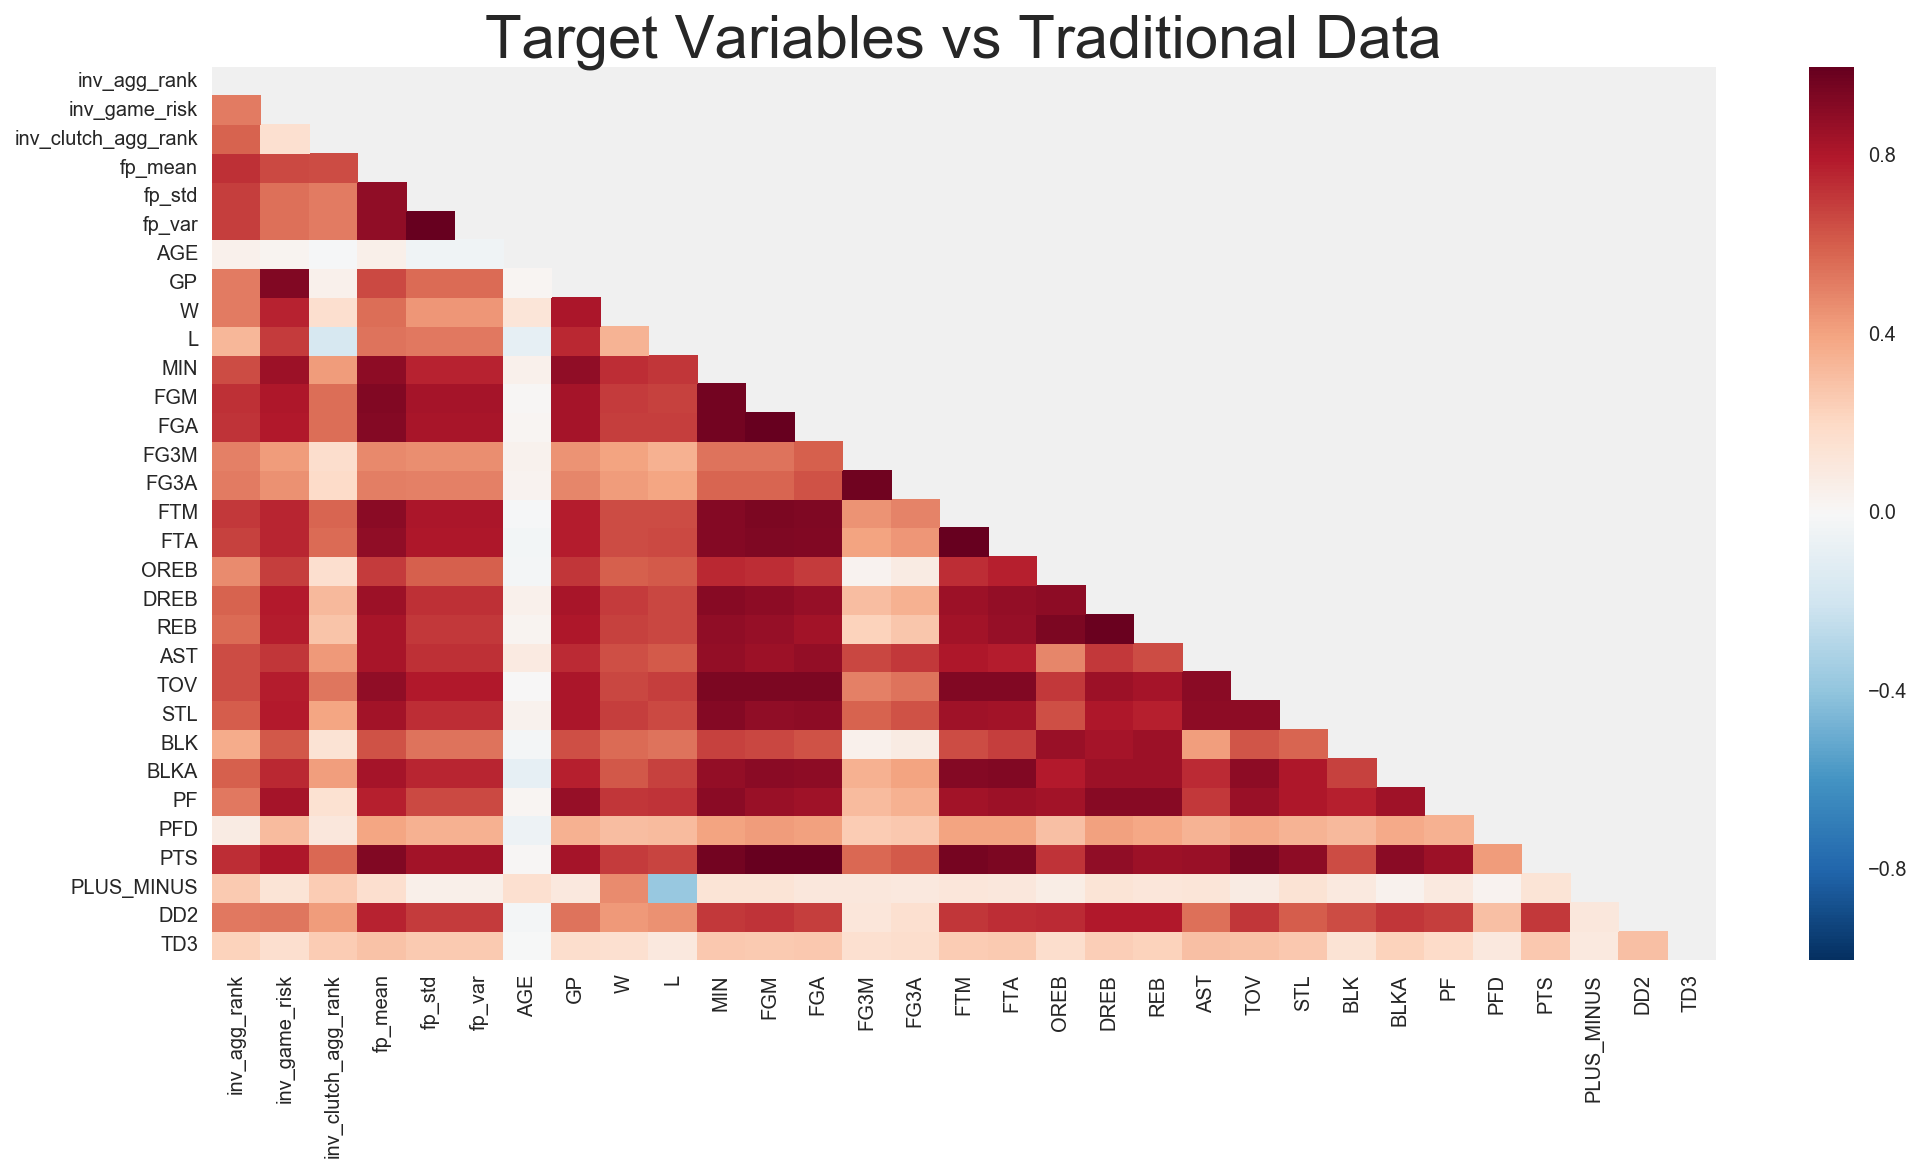

In [16]:
mask = np.zeros_like(df_complete[trad_base_cols].corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(15,8))
ax = fig.gca()

ax = sns.heatmap(df_complete[trad_base_cols].corr(method='spearman'), mask=mask)

ax.set_title('Target Variables vs Traditional Data', size=30)
plt.show()

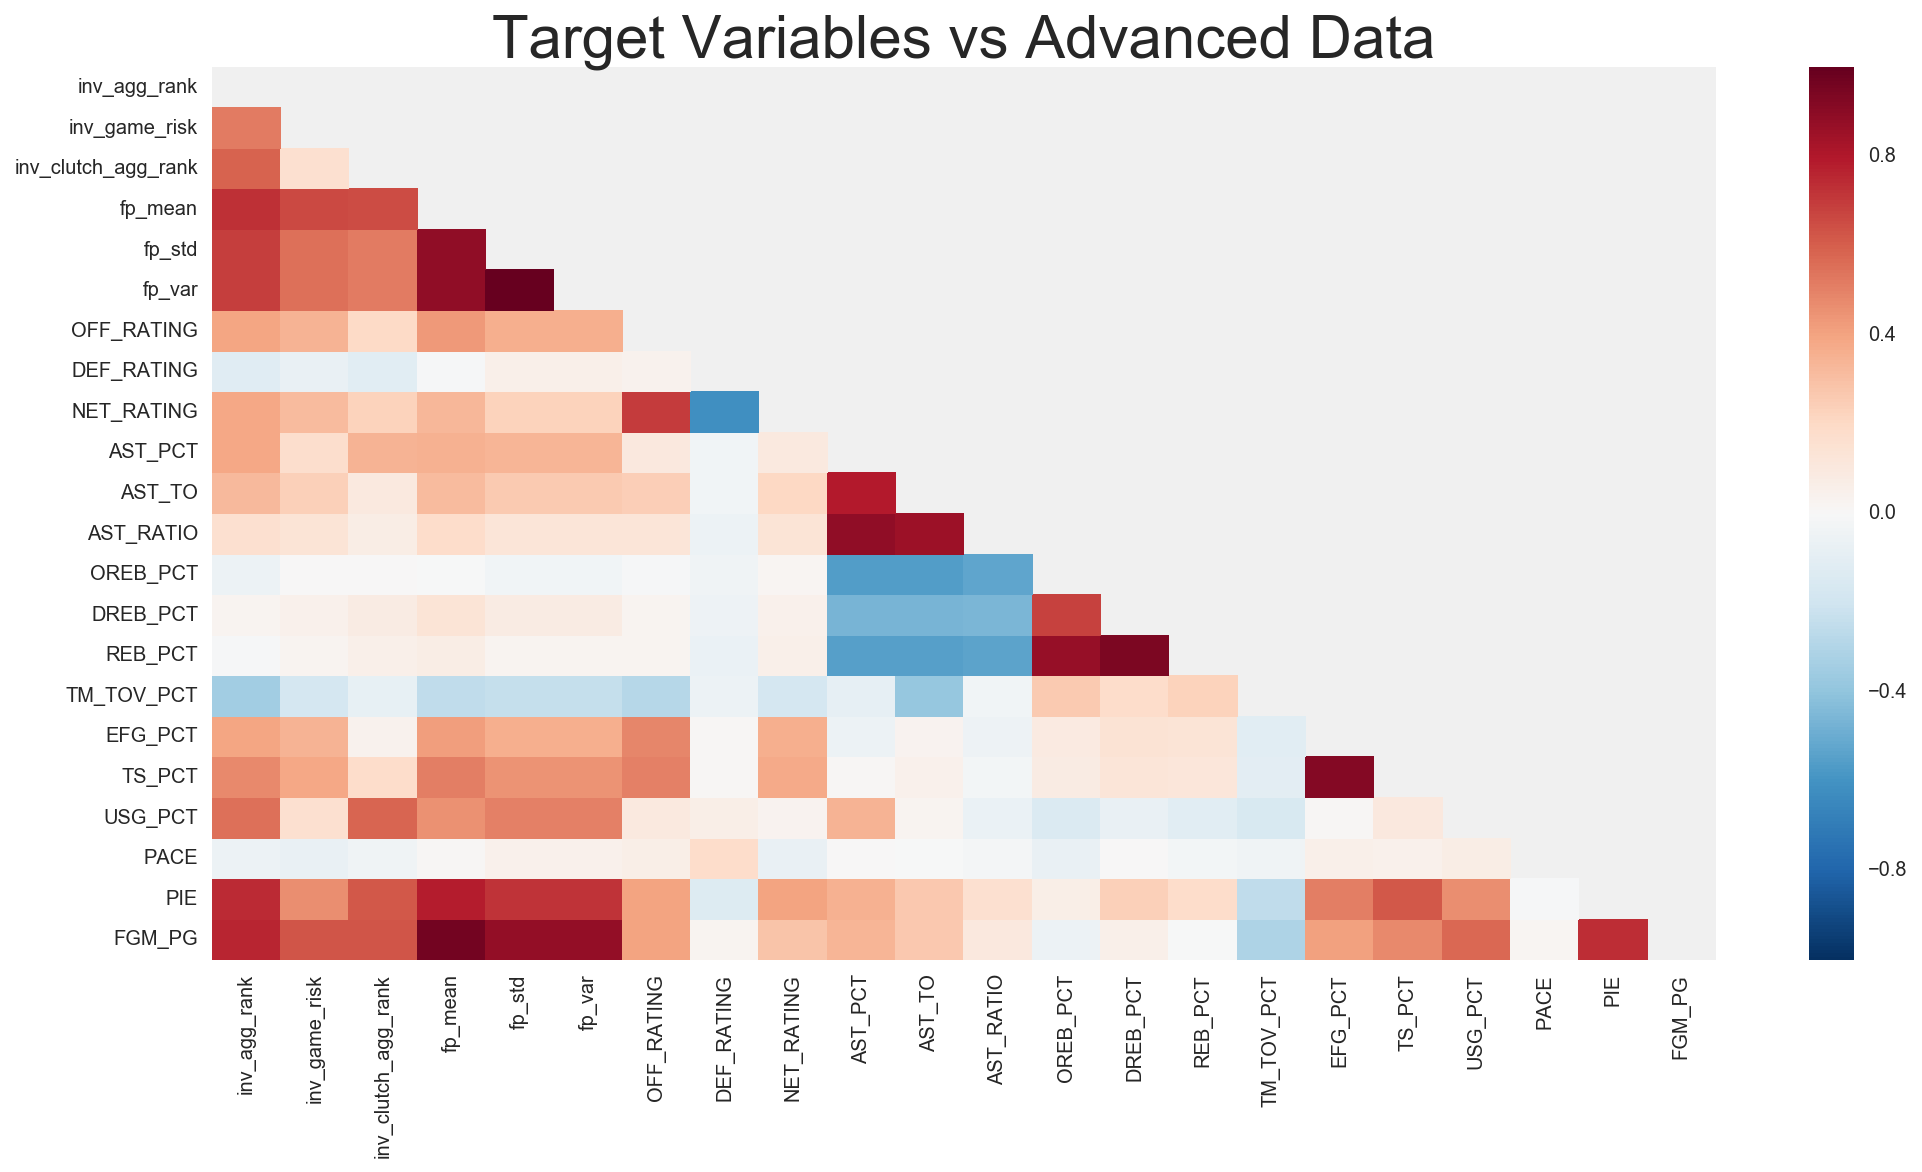

In [17]:
mask = np.zeros_like(df_complete[trad_adv_cols].corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(15,8))
ax = fig.gca()

ax = sns.heatmap(df_complete[trad_adv_cols].corr(method='spearman'), mask=mask)

ax.set_title('Target Variables vs Advanced Data', size=30)
plt.show()

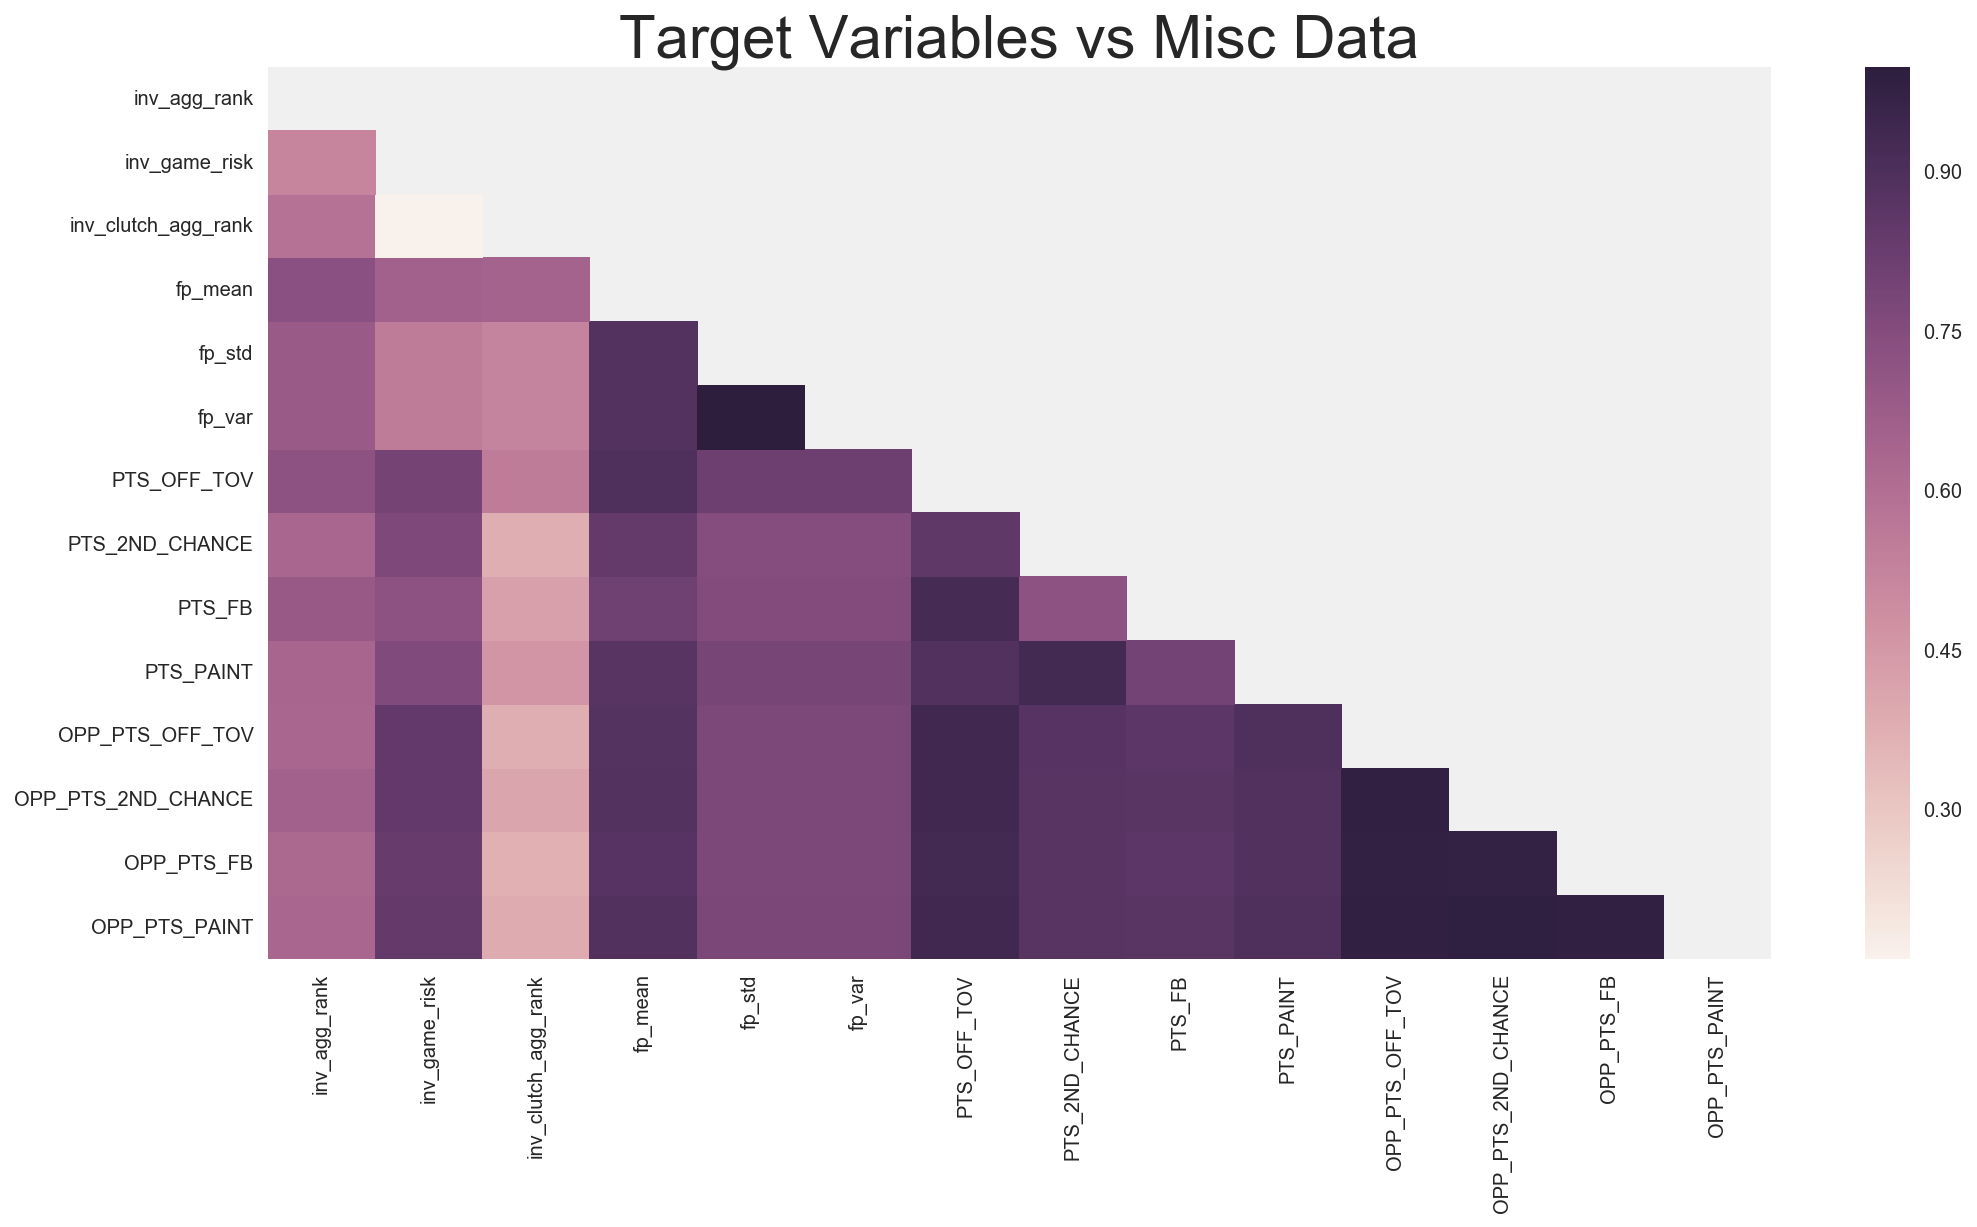

In [18]:
mask = np.zeros_like(df_complete[trad_misc_cols].corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(15,8))
ax = fig.gca()

ax = sns.heatmap(df_complete[trad_misc_cols].corr(method='spearman'), mask=mask)

ax.set_title('Target Variables vs Misc Data', size=30)
plt.show()

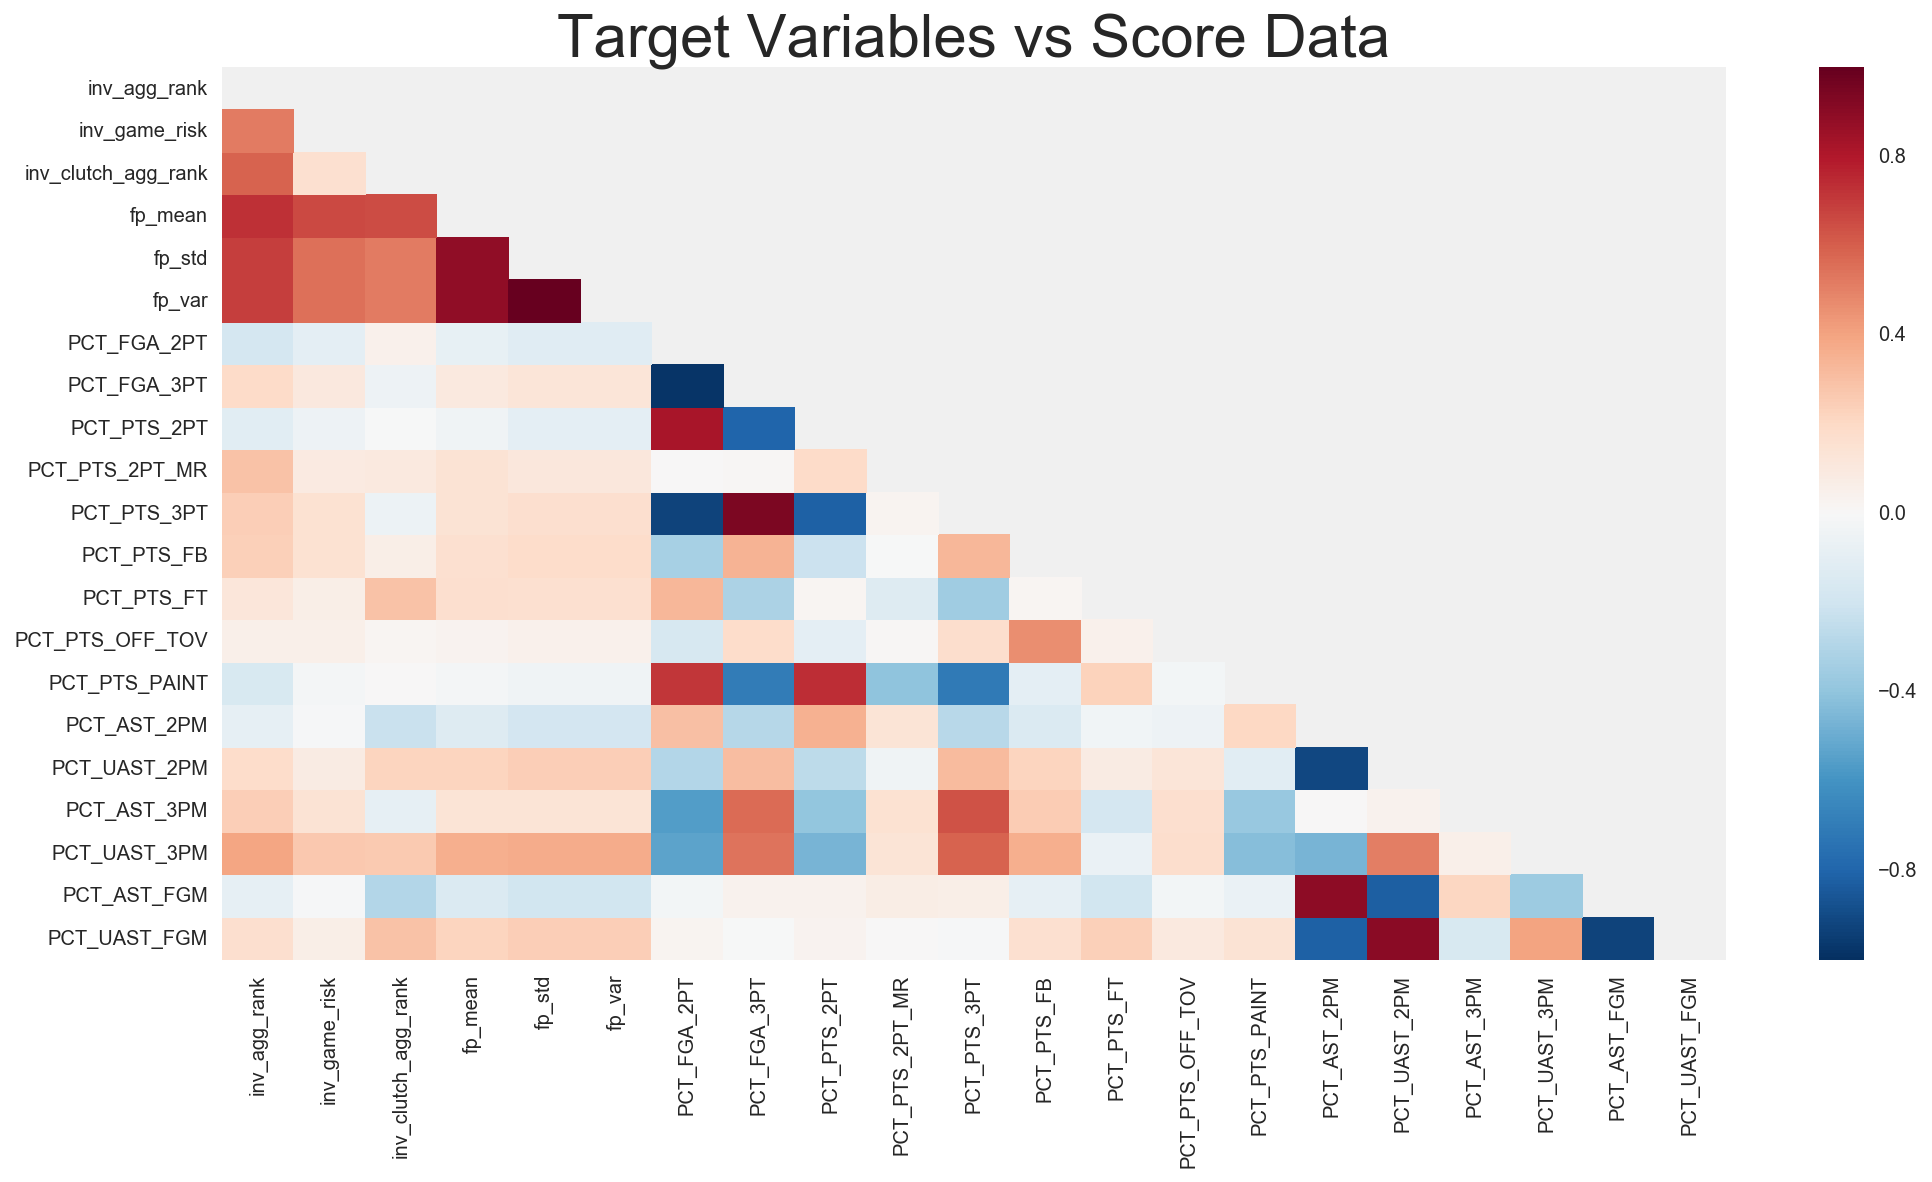

In [19]:
mask = np.zeros_like(df_complete[trad_score_cols].corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(15,8))
ax = fig.gca()

ax = sns.heatmap(df_complete[trad_score_cols].corr(method='spearman'), mask=mask)

ax.set_title('Target Variables vs Score Data', size=30)
plt.show()

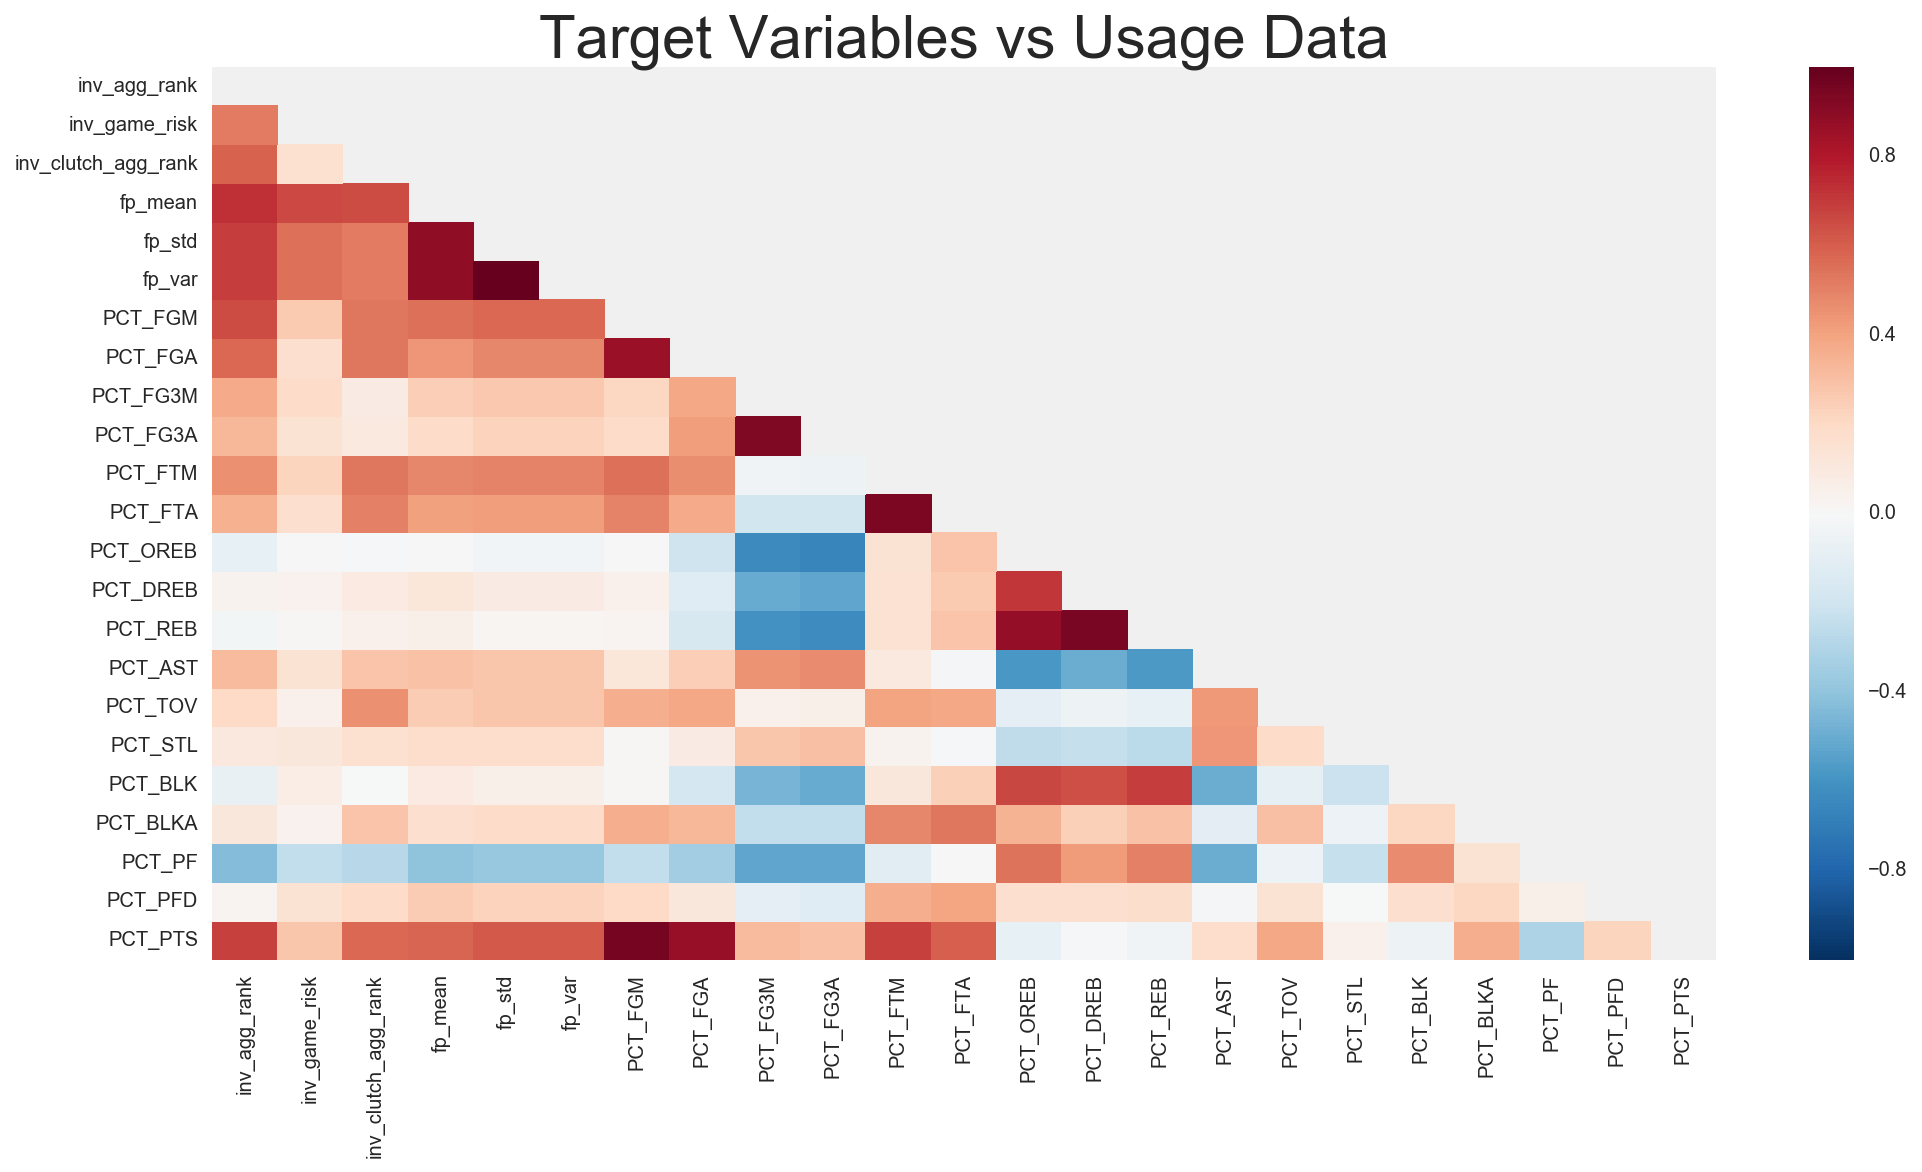

In [20]:
mask = np.zeros_like(df_complete[trad_usage_cols].corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(15,8))
ax = fig.gca()

ax = sns.heatmap(df_complete[trad_usage_cols].corr(method='spearman'), mask=mask)

ax.set_title('Target Variables vs Usage Data', size=30)
plt.show()

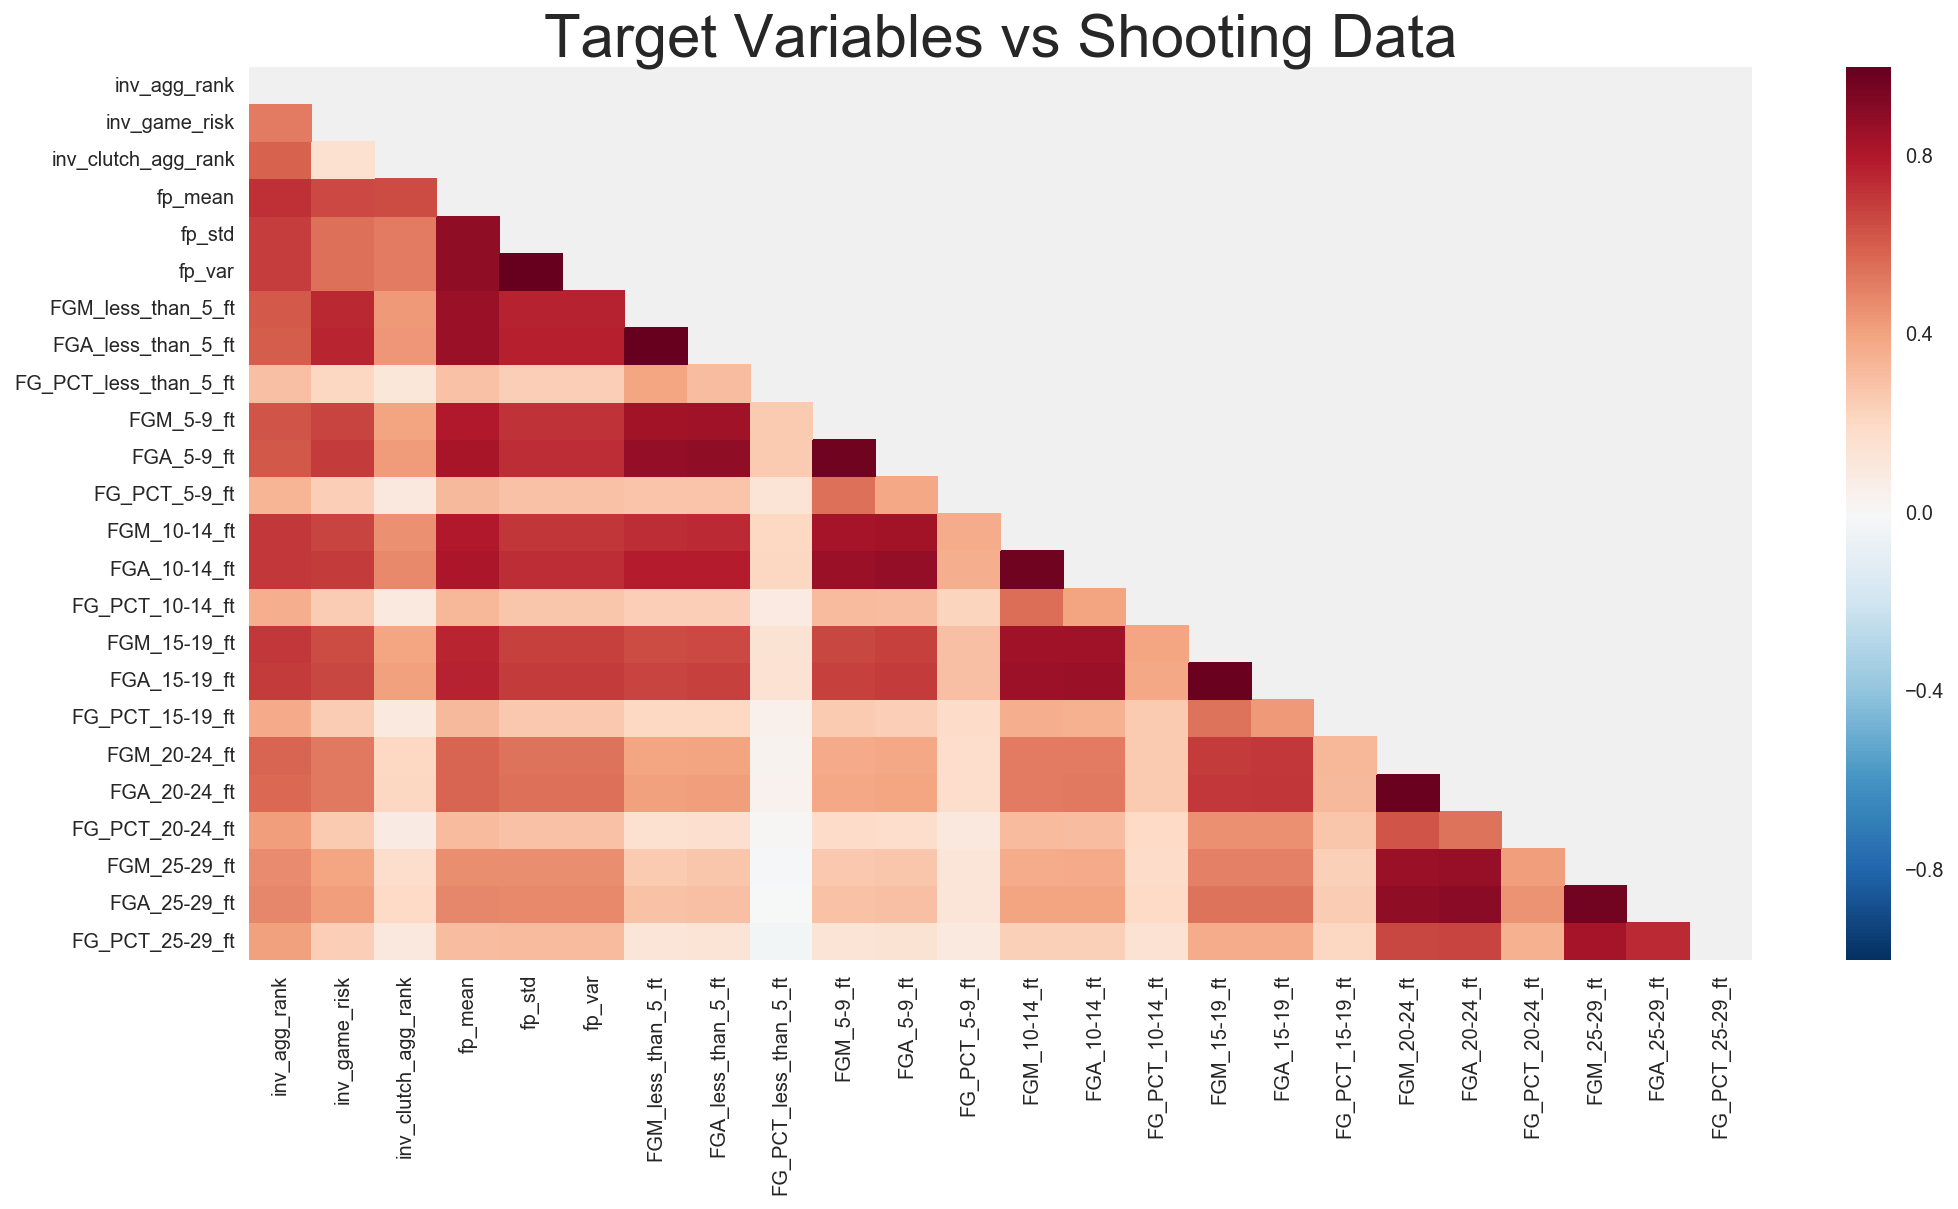

In [21]:
mask = np.zeros_like(df_complete[shooting_cols].corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(15,8))
ax = fig.gca()

ax = sns.heatmap(df_complete[shooting_cols].corr(method='spearman'), mask=mask)

ax.set_title('Target Variables vs Shooting Data', size=30)
plt.show()

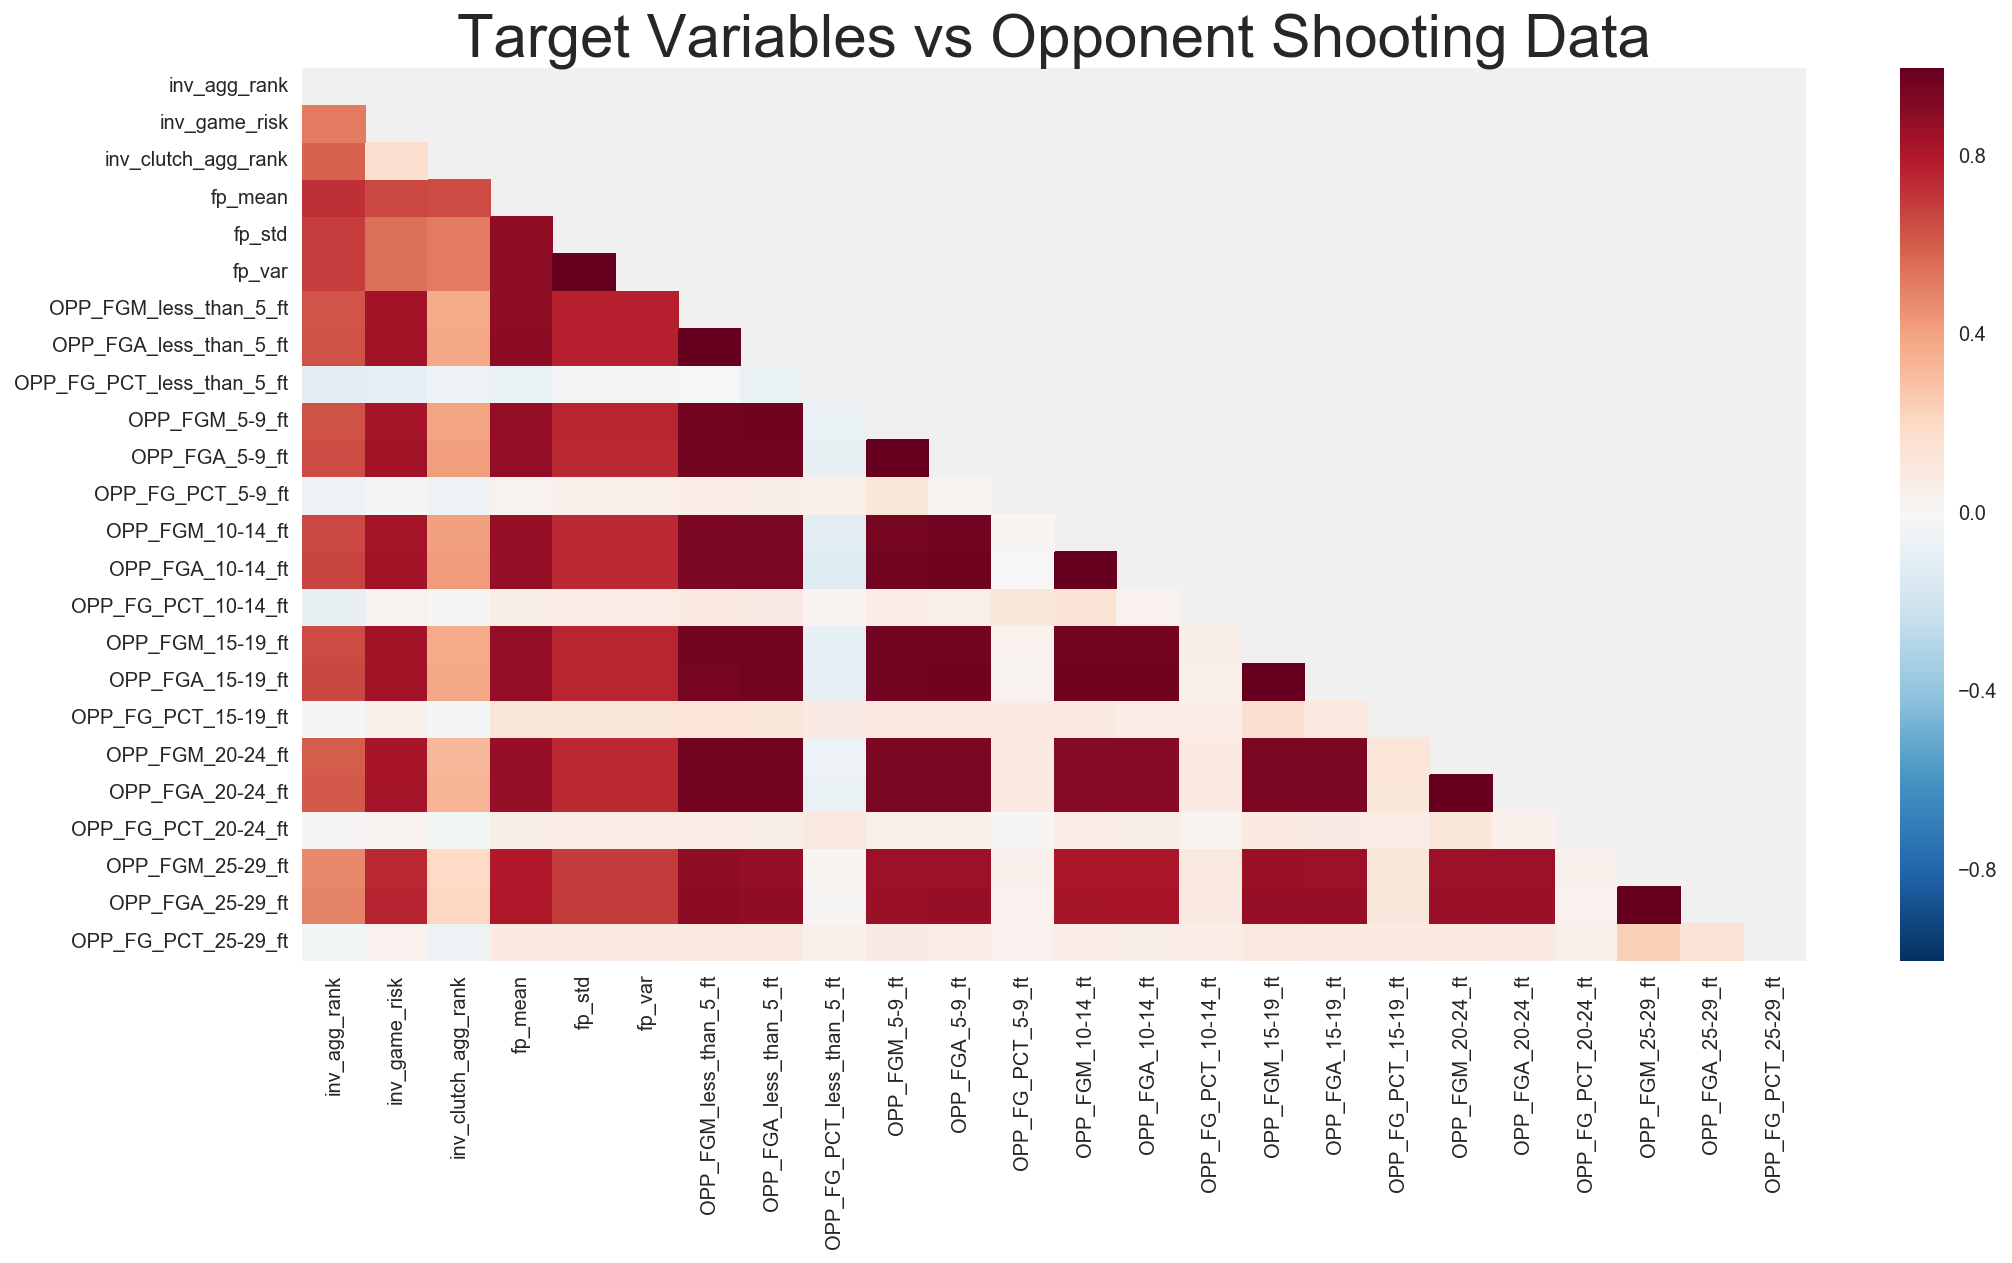

In [22]:
mask = np.zeros_like(df_complete[opp_shooting_cols].corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(15,8))
ax = fig.gca()

ax = sns.heatmap(df_complete[opp_shooting_cols].corr(method='spearman'), mask=mask)

ax.set_title('Target Variables vs Opponent Shooting Data', size=30)
plt.show()

# ========================================================
# Keep positively correlated features for each target
# ========================================================

In [23]:
pos_corr_agg = ['inv_agg_rank',
                u'PCT_FGM', u'PCT_FGA', u'PCT_FG3M', u'PCT_FG3A',
       u'PCT_FTM', u'PCT_FTA', u'PCT_DREB', u'PCT_REB',
       u'PCT_AST', u'PCT_TOV', u'PCT_STL', u'PCT_BLKA', 
       u'PCT_PFD', u'PCT_PTS', u'PCT_FGA_2PT', u'PCT_FGA_3PT', u'PCT_PTS_2PT', u'PCT_PTS_2PT_MR',
       u'PCT_PTS_3PT', u'PCT_PTS_FB', u'PCT_PTS_FT', u'PCT_PTS_OFF_TOV',
       u'PCT_UAST_2PM', u'PCT_AST_3PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM',
       u'OFF_RATING', u'NET_RATING', u'AST_PCT', u'AST_TO',
       u'AST_RATIO', u'DREB_PCT', u'REB_PCT', u'TM_TOV_PCT',
       u'EFG_PCT', u'TS_PCT', u'USG_PCT', u'PIE', u'FGM_PG',
       u'GP', u'W', u'L', u'MIN', u'FTM', u'FTA',
       u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK',
       u'BLKA', u'PF', u'PFD', u'PTS', u'PLUS_MINUS', u'DD2', u'TD3',
       u'PTS_OFF_TOV', u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_PAINT',
       u'OPP_PTS_OFF_TOV', u'OPP_PTS_2ND_CHANCE', u'OPP_PTS_FB',
       u'OPP_PTS_PAINT', u'FGM_less_than_5_ft',
       u'FGA_less_than_5_ft', u'FGM_5-9_ft', u'FGA_5-9_ft', u'FGM_10-14_ft', u'FGA_10-14_ft', u'FGM_15-19_ft', 
       u'FGA_15-19_ft', u'FGM_20-24_ft', u'FGA_20-24_ft', u'FGM_25-29_ft', u'FGA_25-29_ft', 
       u'OPP_FGM_less_than_5_ft', u'OPP_FGA_less_than_5_ft', u'OPP_FGM_5-9_ft', u'OPP_FGA_5-9_ft', 
       u'OPP_FGM_10-14_ft', u'OPP_FGA_10-14_ft', u'OPP_FGM_15-19_ft', u'OPP_FGA_15-19_ft', u'OPP_FGM_20-24_ft', 
       u'OPP_FGA_20-24_ft', u'OPP_FGM_25-29_ft', u'OPP_FGA_25-29_ft']

In [24]:
pos_corr_clutch_agg = ['inv_clutch_agg_rank',
                       u'PCT_FGM', u'PCT_FGA', u'PCT_FG3A',
       u'PCT_FTM', u'PCT_FTA', u'PCT_DREB', u'PCT_REB',
       u'PCT_AST', u'PCT_TOV', u'PCT_STL', u'PCT_BLKA', 
       u'PCT_PFD', u'PCT_PTS', u'PCT_FGA_2PT', u'PCT_PTS_2PT', u'PCT_PTS_2PT_MR',
       u'PCT_PTS_FB', u'PCT_PTS_FT', u'PCT_PTS_OFF_TOV',
       u'PCT_UAST_2PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM',
       u'OFF_RATING', u'NET_RATING', u'AST_PCT', u'AST_TO',
       u'AST_RATIO', u'DREB_PCT', u'REB_PCT',
       u'TS_PCT', u'USG_PCT', u'PIE', u'FGM_PG',
       u'W', u'MIN', u'FTM', u'FTA',
       u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK',
       u'BLKA', u'PF', u'PFD', u'PTS', u'PLUS_MINUS', u'DD2', u'TD3',
       u'PTS_OFF_TOV', u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_PAINT',
       u'OPP_PTS_OFF_TOV', u'OPP_PTS_2ND_CHANCE', u'OPP_PTS_FB',
       u'OPP_PTS_PAINT', u'FGM_less_than_5_ft',
       u'FGA_less_than_5_ft', u'FGM_5-9_ft', u'FGA_5-9_ft', u'FGM_10-14_ft', u'FGA_10-14_ft', u'FGM_15-19_ft', 
       u'FGA_15-19_ft', u'FGM_20-24_ft', u'FGA_20-24_ft', u'FGM_25-29_ft', u'FGA_25-29_ft', 
       u'OPP_FGM_less_than_5_ft', u'OPP_FGA_less_than_5_ft', u'OPP_FGM_5-9_ft', u'OPP_FGA_5-9_ft', 
       u'OPP_FGM_10-14_ft', u'OPP_FGA_10-14_ft', u'OPP_FGM_15-19_ft', u'OPP_FGA_15-19_ft', u'OPP_FGM_20-24_ft', 
       u'OPP_FGA_20-24_ft', u'OPP_FGM_25-29_ft', u'OPP_FGA_25-29_ft']

In [25]:
pos_corr_risk = ['inv_game_risk',
                 u'PCT_FGM', u'PCT_FGA', u'PCT_FG3M', u'PCT_FG3A',
       u'PCT_FTM', u'PCT_FTA', u'PCT_DREB', 
       u'PCT_AST', u'PCT_STL', 
       u'PCT_PFD', u'PCT_PTS', u'PCT_FGA_3PT', u'PCT_PTS_2PT_MR',
       u'PCT_PTS_3PT', u'PCT_PTS_FB', u'PCT_PTS_OFF_TOV',
       u'PCT_UAST_2PM', u'PCT_AST_3PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM',
       u'OFF_RATING', u'NET_RATING', u'AST_PCT', u'AST_TO',
       u'AST_RATIO', u'DREB_PCT',
       u'EFG_PCT', u'TS_PCT', u'USG_PCT', u'PIE', u'FGM_PG',
       u'GP', u'W', u'L', u'MIN', u'FTM', u'FTA',
       u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK',
       u'BLKA', u'PF', u'PFD', u'PTS', u'PLUS_MINUS', u'DD2', u'TD3',
       u'PTS_OFF_TOV', u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_PAINT',
       u'OPP_PTS_OFF_TOV', u'OPP_PTS_2ND_CHANCE', u'OPP_PTS_FB',
       u'OPP_PTS_PAINT', u'FGM_less_than_5_ft',
       u'FGA_less_than_5_ft', u'FGM_5-9_ft', u'FGA_5-9_ft', u'FGM_10-14_ft', u'FGA_10-14_ft', u'FGM_15-19_ft', 
       u'FGA_15-19_ft', u'FGM_20-24_ft', u'FGA_20-24_ft', u'FGM_25-29_ft', u'FGA_25-29_ft', 
       u'OPP_FGM_less_than_5_ft', u'OPP_FGA_less_than_5_ft', u'OPP_FGM_5-9_ft', u'OPP_FGA_5-9_ft', 
       u'OPP_FGM_10-14_ft', u'OPP_FGA_10-14_ft', u'OPP_FGM_15-19_ft', u'OPP_FGA_15-19_ft', u'OPP_FGM_20-24_ft', 
       u'OPP_FGA_20-24_ft', u'OPP_FGM_25-29_ft', u'OPP_FGA_25-29_ft']

In [26]:
pos_corr_fp_mean = ['fp_mean',
                    u'PCT_FGM', u'PCT_FGA', u'PCT_FG3M', u'PCT_FG3A',
       u'PCT_FTM', u'PCT_FTA', u'PCT_DREB', u'PCT_REB',
       u'PCT_AST', u'PCT_TOV', u'PCT_STL', u'PCT_BLKA', 
       u'PCT_PFD', u'PCT_PTS', u'PCT_FGA_2PT', u'PCT_PTS_2PT', u'PCT_PTS_2PT_MR',
       u'PCT_PTS_FB', u'PCT_PTS_FT',
       u'PCT_UAST_2PM', u'PCT_AST_3PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM',
       u'OFF_RATING', u'NET_RATING', u'AST_PCT', u'AST_TO',
       u'AST_RATIO', u'DREB_PCT', u'REB_PCT',
       u'EFG_PCT', u'TS_PCT', u'USG_PCT', u'PIE', u'FGM_PG',
       u'GP', u'W', u'L', u'MIN', u'FTM', u'FTA',
       u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK',
       u'BLKA', u'PF', u'PFD', u'PTS', u'PLUS_MINUS', u'DD2', u'TD3',
       u'PTS_OFF_TOV', u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_PAINT',
       u'OPP_PTS_OFF_TOV', u'OPP_PTS_2ND_CHANCE', u'OPP_PTS_FB',
       u'OPP_PTS_PAINT', u'FGM_less_than_5_ft',
       u'FGA_less_than_5_ft', u'FGM_5-9_ft', u'FGA_5-9_ft', u'FGM_10-14_ft', u'FGA_10-14_ft', u'FGM_15-19_ft', 
       u'FGA_15-19_ft', u'FGM_20-24_ft', u'FGA_20-24_ft', u'FGM_25-29_ft', u'FGA_25-29_ft', 
       u'OPP_FGM_less_than_5_ft', u'OPP_FGA_less_than_5_ft', u'OPP_FGM_5-9_ft', u'OPP_FGA_5-9_ft', 
       u'OPP_FGM_10-14_ft', u'OPP_FGA_10-14_ft', u'OPP_FGM_15-19_ft', u'OPP_FGA_15-19_ft', u'OPP_FGM_20-24_ft', 
       u'OPP_FGA_20-24_ft', u'OPP_FGM_25-29_ft', u'OPP_FGA_25-29_ft']

In [27]:
pos_corr_fp_std = ['fp_std',
                   u'PCT_FGM', u'PCT_FGA', u'PCT_FG3M', u'PCT_FG3A',
       u'PCT_FTM', u'PCT_FTA', u'PCT_DREB',
       u'PCT_AST', u'PCT_TOV', u'PCT_STL', u'PCT_BLKA', 
       u'PCT_PFD', u'PCT_PTS', u'PCT_FGA_3PT',
       u'PCT_PTS_3PT', u'PCT_PTS_FB', u'PCT_PTS_FT', u'PCT_PTS_OFF_TOV',
       u'PCT_UAST_2PM', u'PCT_AST_3PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM',
       u'OFF_RATING', u'NET_RATING', u'AST_PCT', u'AST_TO',
       u'AST_RATIO', u'DREB_PCT', u'REB_PCT',
       u'EFG_PCT', u'TS_PCT', u'USG_PCT', u'PIE', u'FGM_PG',
       u'GP', u'W', u'L', u'MIN', u'FTM', u'FTA',
       u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK',
       u'BLKA', u'PF', u'PFD', u'PTS', u'DD2', u'TD3',
       u'PTS_OFF_TOV', u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_PAINT',
       u'OPP_PTS_OFF_TOV', u'OPP_PTS_2ND_CHANCE', u'OPP_PTS_FB',
       u'OPP_PTS_PAINT', u'FGM_less_than_5_ft',
       u'FGA_less_than_5_ft', u'FGM_5-9_ft', u'FGA_5-9_ft', u'FGM_10-14_ft', u'FGA_10-14_ft', u'FGM_15-19_ft', 
       u'FGA_15-19_ft', u'FGM_20-24_ft', u'FGA_20-24_ft', u'FGM_25-29_ft', u'FGA_25-29_ft', 
       u'OPP_FGM_less_than_5_ft', u'OPP_FGA_less_than_5_ft', u'OPP_FGM_5-9_ft', u'OPP_FGA_5-9_ft', 
       u'OPP_FGM_10-14_ft', u'OPP_FGA_10-14_ft', u'OPP_FGM_15-19_ft', u'OPP_FGA_15-19_ft', u'OPP_FGM_20-24_ft', 
       u'OPP_FGA_20-24_ft', u'OPP_FGM_25-29_ft', u'OPP_FGA_25-29_ft']

In [28]:
pos_corr_fp_var = ['fp_var',
                   u'PCT_FGM', u'PCT_FGA', u'PCT_FG3M', u'PCT_FG3A',
       u'PCT_FTM', u'PCT_FTA', u'PCT_DREB',
       u'PCT_AST', u'PCT_TOV', u'PCT_STL', u'PCT_BLKA', 
       u'PCT_PFD', u'PCT_PTS', u'PCT_FGA_3PT',
       u'PCT_PTS_3PT', u'PCT_PTS_FB', u'PCT_PTS_FT', u'PCT_PTS_OFF_TOV',
       u'PCT_UAST_2PM', u'PCT_AST_3PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM',
       u'OFF_RATING', u'NET_RATING', u'AST_PCT', u'AST_TO',
       u'AST_RATIO', u'DREB_PCT', u'REB_PCT',
       u'EFG_PCT', u'TS_PCT', u'USG_PCT', u'PIE', u'FGM_PG',
       u'GP', u'W', u'L', u'MIN', u'FTM', u'FTA',
       u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK',
       u'BLKA', u'PF', u'PFD', u'PTS', u'DD2', u'TD3',
       u'PTS_OFF_TOV', u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_PAINT',
       u'OPP_PTS_OFF_TOV', u'OPP_PTS_2ND_CHANCE', u'OPP_PTS_FB',
       u'OPP_PTS_PAINT', u'FGM_less_than_5_ft',
       u'FGA_less_than_5_ft', u'FGM_5-9_ft', u'FGA_5-9_ft', u'FGM_10-14_ft', u'FGA_10-14_ft', u'FGM_15-19_ft', 
       u'FGA_15-19_ft', u'FGM_20-24_ft', u'FGA_20-24_ft', u'FGM_25-29_ft', u'FGA_25-29_ft', 
       u'OPP_FGM_less_than_5_ft', u'OPP_FGA_less_than_5_ft', u'OPP_FGM_5-9_ft', u'OPP_FGA_5-9_ft', 
       u'OPP_FGM_10-14_ft', u'OPP_FGA_10-14_ft', u'OPP_FGM_15-19_ft', u'OPP_FGA_15-19_ft', u'OPP_FGM_20-24_ft', 
       u'OPP_FGA_20-24_ft', u'OPP_FGM_25-29_ft', u'OPP_FGA_25-29_ft']

# ========================================================
# Setup Train-Test split for each target variable and their features
# ========================================================

In [29]:
# Creating 3 dataframes because clutch stats has 50% null values in target and std/var have a couple of null values
df_model = pd.read_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/completed/complete_all.csv')
df_model_clutch = pd.read_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/completed/complete_all.csv')
df_model_std_var = pd.read_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/completed/complete_all.csv')

In [30]:
df_model.drop('Unnamed: 0', axis=1,inplace=True)
df_model_clutch.drop('Unnamed: 0', axis=1,inplace=True)
df_model_std_var.drop('Unnamed: 0', axis=1,inplace=True)

# Drop all NaN values from player name, team abbreviation and age
df_model.dropna(subset=['PLAYER_NAME', 'TEAM_ABBREVIATION', 'AGE'], how='all', inplace=True)
df_model_clutch.dropna(subset=['PLAYER_NAME', 'TEAM_ABBREVIATION', 'AGE'], how='all', inplace=True)
df_model_std_var.dropna(subset=['PLAYER_NAME', 'TEAM_ABBREVIATION', 'AGE'], how='all', inplace=True)

In [31]:
df_model['inv_agg_rank'] = df_complete['agg_rank'] * -1
df_model['inv_game_risk'] = df_complete['game_risk'] * -1
df_model_clutch['inv_clutch_agg_rank'] = df_complete['clutch_agg_rank'] * -1

In [32]:
# Dropping clutch rank since it will not be used in this dataframe
df_model.drop('clutch_agg_rank', inplace=True, axis=1)
df_model_std_var.drop('clutch_agg_rank', inplace=True, axis=1)

In [33]:
# Features that were previously removed from creating dummy variables
df_model.drop(['FGM_30-34_ft', 'FGA_30-34_ft', 'FG_PCT_30-34_ft',
              'FGM_35-39_ft', 'FGA_35-39_ft', 'FG_PCT_35-39_ft',
              'FGM_40+_ft', 'FGA_40+_ft', 'FG_PCT_40+_ft',
              'OPP_FGM_30-34_ft', 'OPP_FGA_30-34_ft', 'OPP_FG_PCT_30-34_ft',
              'OPP_FGM_35-39_ft', 'OPP_FGA_35-39_ft', 'OPP_FG_PCT_35-39_ft',
              'OPP_FGM_40+_ft', 'OPP_FGA_40+_ft', 'OPP_FG_PCT_40+_ft',], axis=1, inplace=True)

In [34]:
# Features that were previously removed from creating dummy variables
df_model_clutch.drop(['FGM_30-34_ft', 'FGA_30-34_ft', 'FG_PCT_30-34_ft',
              'FGM_35-39_ft', 'FGA_35-39_ft', 'FG_PCT_35-39_ft',
              'FGM_40+_ft', 'FGA_40+_ft', 'FG_PCT_40+_ft',
              'OPP_FGM_30-34_ft', 'OPP_FGA_30-34_ft', 'OPP_FG_PCT_30-34_ft',
              'OPP_FGM_35-39_ft', 'OPP_FGA_35-39_ft', 'OPP_FG_PCT_35-39_ft',
              'OPP_FGM_40+_ft', 'OPP_FGA_40+_ft', 'OPP_FG_PCT_40+_ft',], axis=1, inplace=True)

In [35]:
# Features that were previously removed from creating dummy variables
df_model_std_var.drop(['FGM_30-34_ft', 'FGA_30-34_ft', 'FG_PCT_30-34_ft',
              'FGM_35-39_ft', 'FGA_35-39_ft', 'FG_PCT_35-39_ft',
              'FGM_40+_ft', 'FGA_40+_ft', 'FG_PCT_40+_ft',
              'OPP_FGM_30-34_ft', 'OPP_FGA_30-34_ft', 'OPP_FG_PCT_30-34_ft',
              'OPP_FGM_35-39_ft', 'OPP_FGA_35-39_ft', 'OPP_FG_PCT_35-39_ft',
              'OPP_FGM_40+_ft', 'OPP_FGA_40+_ft', 'OPP_FG_PCT_40+_ft',], axis=1, inplace=True)

In [36]:
df_model.dropna(inplace=True)
df_model_clutch.dropna(inplace=True)
df_model_std_var.dropna(inplace=True)

In [37]:
# Setup trainX and trainY for each target variable to run on
df_corr_agg = df_model[pos_corr_agg]
df_corr_game_risk = df_model[pos_corr_risk]
df_corr_fp_mean = df_model[pos_corr_fp_mean]

# Specifically for std and var due to difference NaN values
df_corr_fp_std = df_model_std_var[pos_corr_fp_std]
df_corr_fp_var = df_model_std_var[pos_corr_fp_var]

# Specifically for clutch due to different NaN values
df_corr_clutch_agg = df_model_clutch[pos_corr_clutch_agg]

In [38]:
y_agg = df_corr_agg.inv_agg_rank.values
X_agg = df_corr_agg.ix[:,1:]

y_clutch = df_corr_clutch_agg.inv_clutch_agg_rank.values
X_clutch = df_corr_clutch_agg.ix[:,1:]

y_game_risk = df_corr_game_risk.inv_game_risk.values
X_game_risk = df_corr_game_risk.ix[:,1:]

y_fp_mean = df_corr_fp_mean.fp_mean.values
X_fp_mean = df_corr_fp_mean.ix[:,1:]

y_fp_std = df_corr_fp_std.fp_std.values
X_fp_std = df_corr_fp_std.ix[:,1:]

y_fp_var = df_corr_fp_var.fp_var.values
X_fp_var = df_corr_fp_var.ix[:,1:]

In [39]:
print 'Original DF shape: ', df_model.shape, df_model_clutch.shape, df_model_std_var.shape
print 'Agg shape: ', X_agg.shape, y_agg.shape
print 'Clutch Agg shape: ', X_clutch.shape, y_clutch.shape
print 'Game Risk shape: ', X_game_risk.shape, y_game_risk.shape
print 'FP Mean shape: ', X_fp_mean.shape, y_fp_mean.shape
print 'FP Std shape: ', X_fp_std.shape, y_fp_std.shape
print 'FP Var shape: ', X_fp_var.shape, y_fp_var.shape

Original DF shape:  (8962, 230) (4940, 230) (8962, 228)
Agg shape:  (8962, 91) (8962,)
Clutch Agg shape:  (4940, 83) (4940,)
Game Risk shape:  (8962, 83) (8962,)
FP Mean shape:  (8962, 87) (8962,)
FP Std shape:  (8962, 85) (8962,)
FP Var shape:  (8962, 85) (8962,)


In [40]:
ss = StandardScaler()

X_agg_n = ss.fit_transform(X_agg)
X_clutch_n = ss.fit_transform(X_clutch)
X_game_risk_n = ss.fit_transform(X_game_risk)
X_fp_mean_n = ss.fit_transform(X_fp_mean)
X_fp_std_n = ss.fit_transform(X_fp_std)
X_fp_var_n = ss.fit_transform(X_fp_var)

In [41]:
# Train-Test split for Linear/Logistic Regression

trainX_agg_n, testX_agg_n, trainY_agg_n, testY_agg_n = train_test_split(X_agg_n, y_agg, train_size=0.75)
print 'Agg Rank\n'
print trainX_agg_n.shape, trainY_agg_n.shape
print testX_agg_n.shape, testY_agg_n.shape
print '=======================\n'

trainX_clutch_n, testX_clutch_n, trainY_clutch_n, testY_clutch_n = train_test_split(X_clutch_n, y_clutch, train_size=0.75)
print 'Agg Clutch Rank\n'
print trainX_clutch_n.shape, trainY_clutch_n.shape
print testX_clutch_n.shape, testY_clutch_n.shape
print '=======================\n'

trainX_game_risk_n, testX_game_risk_n, trainY_game_risk_n, testY_game_risk_n = train_test_split(X_game_risk_n, y_game_risk, train_size=0.75, stratify=y_game_risk)
print 'Game Risk\n'
print trainX_game_risk_n.shape, trainY_game_risk_n.shape
print testX_game_risk_n.shape, testY_game_risk_n.shape
print '=======================\n'

trainX_fp_mean_n, testX_fp_mean_n, trainY_fp_mean_n, testY_fp_mean_n = train_test_split(X_fp_mean_n, y_fp_mean, train_size=0.75)
print 'FP Mean\n'
print trainX_fp_mean_n.shape, trainY_fp_mean_n.shape
print testX_fp_mean_n.shape, testY_fp_mean_n.shape
print '=======================\n'

trainX_fp_std_n, testX_fp_std_n, trainY_fp_std_n, testY_fp_std_n = train_test_split(X_fp_std_n, y_fp_std, train_size=0.75)
print 'FP Std\n'
print trainX_fp_std_n.shape, trainY_fp_std_n.shape
print testX_fp_std_n.shape, testY_fp_std_n.shape
print '=======================\n'

trainX_fp_var_n, testX_fp_var_n, trainY_fp_var_n, testY_fp_var_n = train_test_split(X_fp_var_n, y_fp_var, train_size=0.75)
print 'FP Var\n'
print trainX_fp_var_n.shape, trainY_fp_var_n.shape
print testX_fp_var_n.shape, testY_fp_var_n.shape
print '=======================\n'

Agg Rank

(6721, 91) (6721,)
(2241, 91) (2241,)

Agg Clutch Rank

(3705, 83) (3705,)
(1235, 83) (1235,)

Game Risk

(6721, 83) (6721,)
(2241, 83) (2241,)

FP Mean

(6721, 87) (6721,)
(2241, 87) (2241,)

FP Std

(6721, 85) (6721,)
(2241, 85) (2241,)

FP Var

(6721, 85) (6721,)
(2241, 85) (2241,)



In [42]:
# Train-Test split for Random Forest

trainX_agg, testX_agg, trainY_agg, testY_agg = train_test_split(X_agg, y_agg, train_size=0.75)
print 'Agg Rank\n'
print trainX_agg.shape, trainY_agg.shape
print testX_agg.shape, testY_agg.shape
print '=======================\n'

trainX_clutch, testX_clutch, trainY_clutch, testY_clutch = train_test_split(X_clutch, y_clutch, train_size=0.75)
print 'Agg Clutch Rank\n'
print trainX_clutch.shape, trainY_clutch.shape
print testX_clutch.shape, testY_clutch.shape
print '=======================\n'

trainX_game_risk, testX_game_risk, trainY_game_risk, testY_game_risk = train_test_split(X_game_risk, y_game_risk, train_size=0.75, stratify=y_game_risk)
print 'Game Risk\n'
print trainX_game_risk.shape, trainY_game_risk.shape
print testX_game_risk.shape, testY_game_risk.shape
print '=======================\n'

trainX_fp_mean, testX_fp_mean, trainY_fp_mean, testY_fp_mean = train_test_split(X_fp_mean, y_fp_mean, train_size=0.75)
print 'FP Mean\n'
print trainX_fp_mean.shape, trainY_fp_mean.shape
print testX_fp_mean.shape, testY_fp_mean.shape
print '=======================\n'

trainX_fp_std, testX_fp_std, trainY_fp_std, testY_fp_std = train_test_split(X_fp_std, y_fp_std, train_size=0.75)
print 'FP Std\n'
print trainX_fp_std.shape, trainY_fp_std.shape
print testX_fp_std.shape, testY_fp_std.shape
print '=======================\n'

trainX_fp_var, testX_fp_var, trainY_fp_var, testY_fp_var = train_test_split(X_fp_var, y_fp_var, train_size=0.75)
print 'FP Var\n'
print trainX_fp_var.shape, trainY_fp_var.shape
print testX_fp_var.shape, testY_fp_var.shape
print '=======================\n'

Agg Rank

(6721, 91) (6721,)
(2241, 91) (2241,)

Agg Clutch Rank

(3705, 83) (3705,)
(1235, 83) (1235,)

Game Risk

(6721, 83) (6721,)
(2241, 83) (2241,)

FP Mean

(6721, 87) (6721,)
(2241, 87) (2241,)

FP Std

(6721, 85) (6721,)
(2241, 85) (2241,)

FP Var

(6721, 85) (6721,)
(2241, 85) (2241,)



In [43]:
# cPickle to save all my train-test dataset for Random Forest
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/trainX_agg.pickle', 'wb') as f:
    pickle.dump(trainX_agg, f)
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/trainY_agg.pickle', 'wb') as f:
    pickle.dump(trainY_agg, f)

with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/trainX_clutch.pickle', 'wb') as f:
    pickle.dump(trainX_clutch, f)
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/trainY_clutch.pickle', 'wb') as f:
    pickle.dump(trainY_clutch, f)

with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/trainX_game_risk.pickle', 'wb') as f:
    pickle.dump(trainX_game_risk, f)
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/trainY_game_risk.pickle', 'wb') as f:
    pickle.dump(trainY_game_risk, f)

with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/trainX_fp_mean.pickle', 'wb') as f:
    pickle.dump(trainX_fp_mean, f)
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/trainY_fp_mean.pickle', 'wb') as f:
    pickle.dump(trainY_fp_mean, f)

with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/trainX_fp_std.pickle', 'wb') as f:
    pickle.dump(trainX_fp_std, f)
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/trainY_fp_std.pickle', 'wb') as f:
    pickle.dump(trainY_fp_std, f)
    
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/trainX_fp_var.pickle', 'wb') as f:
    pickle.dump(trainX_fp_var, f)
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/trainY_fp_var.pickle', 'wb') as f:
    pickle.dump(trainY_fp_var, f)

In [44]:
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_test_data/trainX_fp_mean.pickle', 'wb') as f:
    pickle.dump(trainX_fp_mean, f)
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_test_data/trainY_fp_mean.pickle', 'wb') as f:
    pickle.dump(trainY_fp_mean, f)

with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_test_data/trainX_fp_std.pickle', 'wb') as f:
    pickle.dump(trainX_fp_std, f)
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_test_data/trainY_fp_std.pickle', 'wb') as f:
    pickle.dump(trainY_fp_std, f)
    
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_test_data/trainX_fp_var.pickle', 'wb') as f:
    pickle.dump(trainX_fp_var, f)
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_test_data/trainY_fp_var.pickle', 'wb') as f:
    pickle.dump(trainY_fp_var, f)

# ========================================================
# Linear/Logistic Regression vs Lasso vs Ridge vs ElasticNet
### Compare similar features to eliminate redundancy by correlation matrix
# ========================================================

In [228]:
linreg = LinearRegression()
logreg = LogisticRegression()
logregcv = LogisticRegressionCV(penalty='l2', cv=10, multi_class='multinomial')
knn = KNeighborsClassifier()
encv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_alphas=200, fit_intercept=True, cv=5)
ridgecv = RidgeCV(fit_intercept=True, cv=5, alphas=np.logspace(-5,3,200))
lassocv = LassoCV(n_alphas=200, fit_intercept=True, cv=5)
onevsall = OneVsRestClassifier(AdaBoostClassifier(base_estimator=LogisticRegression(solver='sag'), n_estimators=50))

In [46]:
linreg_params = {
    'fit_intercept': [True, False]
}

logreg_params = {
    'fit_intercept': [True, False],
    'penalty': ['l1', 'l2'],
}

knn_params = {
    'n_neighbors': [3,4,5,6,7],
    'weights': ['uniform', 'distance']
}

In [47]:
estimator_linreg_agg = GridSearchCV(linreg, linreg_params, n_jobs=1,  cv=5, verbose=1)
estimator_linreg_clutch = GridSearchCV(linreg, linreg_params, n_jobs=1,  cv=5, verbose=1)
estimator_linreg_fp_mean = GridSearchCV(linreg, linreg_params, n_jobs=1,  cv=5, verbose=1)
estimator_linreg_fp_std = GridSearchCV(linreg, linreg_params, n_jobs=1,  cv=5, verbose=1)
estimator_linreg_fp_var = GridSearchCV(linreg, linreg_params, n_jobs=1,  cv=5, verbose=1)
estimator_logreg_game_risk = GridSearchCV(logreg, logreg_params, n_jobs=-1, cv=5, verbose=1)
estimator_knn_game_risk = GridSearchCV(knn, knn_params, n_jobs=4, cv=5, verbose=1)

In [229]:
model_logreg_cv = logregcv.fit(trainX_game_risk_n, trainY_game_risk_n)

In [230]:
predict_model_logreg_cv = model_logreg_cv.predict(testX_game_risk_n)

In [231]:
model_logreg_cv.score(testX_game_risk_n, testY_game_risk_n)

0.82597054886211507

In [48]:
estimator_linreg_agg.fit(trainX_agg_n, trainY_agg_n)
estimator_linreg_clutch.fit(trainX_clutch_n, trainY_clutch_n)
estimator_linreg_fp_mean.fit(trainX_fp_mean_n, trainY_fp_mean_n)
estimator_linreg_fp_std.fit(trainX_fp_std_n, trainY_fp_std_n)
estimator_linreg_fp_var.fit(trainX_fp_var_n, trainY_fp_var_n)
estimator_logreg_game_risk.fit(trainX_game_risk_n, trainY_game_risk_n)
estimator_knn_game_risk.fit(trainX_game_risk_n, trainY_game_risk_n)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   27.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   31.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_neighbors': [3, 4, 5, 6, 7], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [49]:
prediction_linreg_agg = estimator_linreg_agg.predict(testX_agg_n)
prediction_linreg_clutch = estimator_linreg_clutch.predict(testX_clutch_n)
prediction_linreg_fp_mean = estimator_linreg_fp_mean.predict(testX_fp_mean_n)
prediction_linreg_fp_std = estimator_linreg_fp_std.predict(testX_fp_std_n)
prediction_linreg_fp_var = estimator_linreg_fp_var.predict(testX_fp_var_n)
prediction_logreg_game_risk_proba = estimator_logreg_game_risk.predict_proba(testX_game_risk_n)
prediction_logreg_game_risk = estimator_logreg_game_risk.predict(testX_game_risk_n)
prediction_knn_game_risk = estimator_knn_game_risk.predict(testX_game_risk_n)

In [50]:
print 'Agg Rank R2: ', estimator_linreg_agg.score(testX_agg_n, testY_agg_n)
print 'Clutch Agg Rank R2: ', estimator_linreg_clutch.score(testX_clutch_n, testY_clutch_n)
print 'FP mean R2: ', estimator_linreg_fp_mean.score(testX_fp_mean_n, testY_fp_mean_n)
print 'FP std R2: ', estimator_linreg_fp_std.score(testX_fp_std_n, testY_fp_std_n)
print 'FP var R2: ', estimator_linreg_fp_var.score(testX_fp_var_n, testY_fp_var_n)
print 'Game Risk Log R2: ', estimator_logreg_game_risk.score(testX_game_risk_n, testY_game_risk_n)
print 'Game Risk knn R2: ', estimator_knn_game_risk.score(testX_game_risk_n, testY_game_risk_n)

Agg Rank R2:  0.847235026198
Clutch Agg Rank R2:  0.55405005639
FP mean R2:  0.996013938834
FP std R2:  0.777050747318
FP var R2:  0.728028010562
Game Risk Log R2:  0.76885319054
Game Risk knn R2:  0.713966979027


# Elastic Net

In [51]:
model_en_agg = encv.fit(trainX_agg_n, trainY_agg_n)
prediction_en_agg = model_en_agg.predict(testX_agg_n)

/Users/edwardlee/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [52]:
model_en_clutch = encv.fit(trainX_clutch_n, trainY_clutch_n)
prediction_en_clutch = model_en_clutch.predict(testX_clutch_n)

In [53]:
model_en_fp_mean = encv.fit(trainX_fp_mean_n, trainY_fp_mean_n)
prediction_en_fp_mean = model_en_fp_mean.predict(testX_fp_mean_n)

In [54]:
model_en_fp_std = encv.fit(trainX_fp_std_n, trainY_fp_std_n)
prediction_en_fp_std = model_en_fp_std.predict(testX_fp_std_n)

In [55]:
model_en_fp_var = encv.fit(trainX_fp_var_n, trainY_fp_var_n)
prediction_en_fp_var = model_en_fp_var.predict(testX_fp_var_n)

In [56]:
model_en_game_risk = encv.fit(trainX_game_risk_n, trainY_game_risk_n)
prediction_en_game_risk = model_en_game_risk.predict(testX_game_risk_n)

# Ridge

In [57]:
model_ridge_agg = ridgecv.fit(trainX_agg_n, trainY_agg_n)
prediction_ridge_agg = model_ridge_agg.predict(testX_agg_n)

In [58]:
model_ridge_clutch = ridgecv.fit(trainX_clutch_n, trainY_clutch_n)
prediction_ridge_clutch = model_ridge_clutch.predict(testX_clutch_n)

In [59]:
model_ridge_fp_mean = ridgecv.fit(trainX_fp_mean_n, trainY_fp_mean_n)
prediction_ridge_fp_mean = model_ridge_fp_mean.predict(testX_fp_mean_n)

In [60]:
model_ridge_fp_std = ridgecv.fit(trainX_fp_std_n, trainY_fp_std_n)
prediction_ridge_fp_std = model_ridge_fp_std.predict(testX_fp_std_n)

In [61]:
model_ridge_fp_var = ridgecv.fit(trainX_fp_var_n, trainY_fp_var_n)
prediction_ridge_fp_var = model_ridge_fp_var.predict(testX_fp_var_n)

In [62]:
model_ridge_game_risk = ridgecv.fit(trainX_game_risk_n, trainY_game_risk_n)
prediction_ridge_game_risk = model_ridge_game_risk.predict(testX_game_risk_n)

# Lasso

In [63]:
model_lasso_agg = lassocv.fit(trainX_agg_n, trainY_agg_n)
prediction_lasso_agg = model_lasso_agg.predict(testX_agg_n)

In [64]:
model_lasso_clutch = lassocv.fit(trainX_clutch_n, trainY_clutch_n)
prediction_lasso_clutch = model_lasso_clutch.predict(testX_clutch_n)

In [65]:
model_lasso_fp_mean = lassocv.fit(trainX_fp_mean_n, trainY_fp_mean_n)
prediction_lasso_fp_mean = model_lasso_fp_mean.predict(testX_fp_mean_n)

In [66]:
model_lasso_fp_std = lassocv.fit(trainX_fp_std_n, trainY_fp_std_n)
prediction_lasso_fp_std = model_lasso_fp_std.predict(testX_fp_std_n)

In [67]:
model_lasso_fp_var = lassocv.fit(trainX_fp_var_n, trainY_fp_var_n)
prediction_lasso_fp_var = model_lasso_fp_var.predict(testX_fp_var_n)

In [68]:
model_lasso_game_risk = lassocv.fit(trainX_game_risk_n, trainY_game_risk_n)
prediction_lasso_game_risk = model_lasso_game_risk.predict(testX_game_risk_n)

# Combined Linear Regression, Lasso, Ridge, ElasticNet Comparison

Agg Rank
R-squared - LinReg 0.847235026198
R-squared - Lasso 0.845985235066
R-squared - Ridge 0.84676931129
R-squared - ElasticNet 0.845985235066


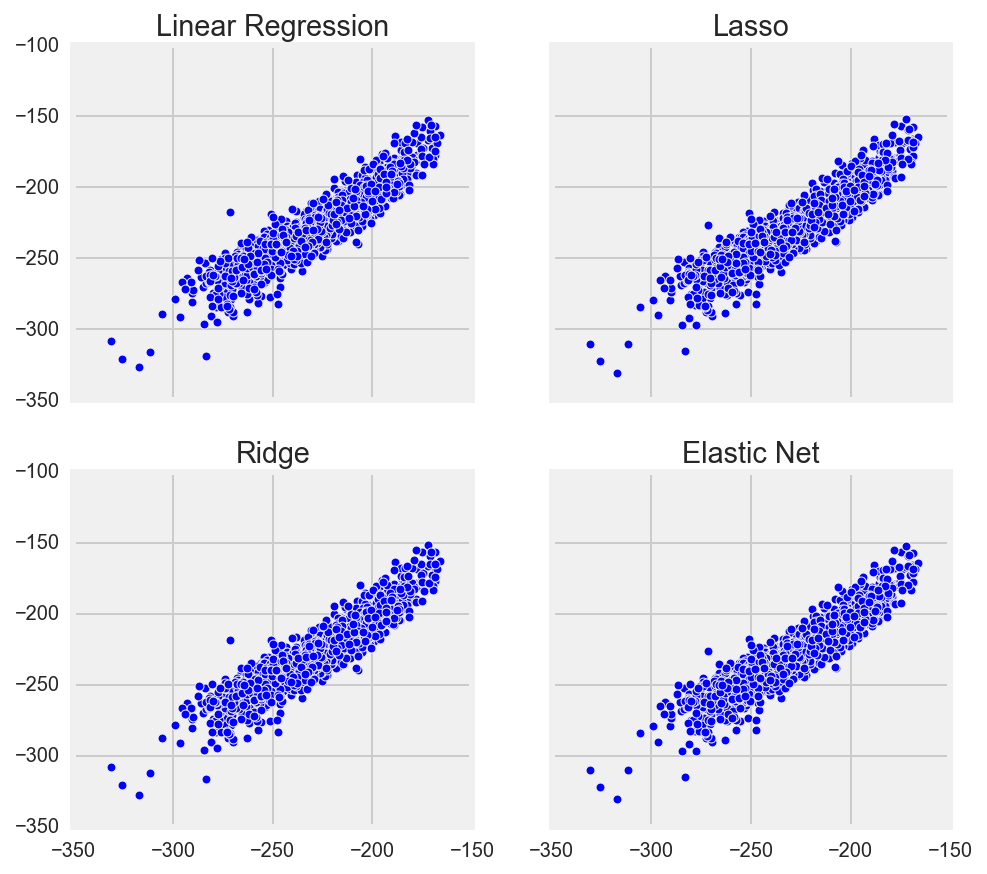


Clutch Rank
R-squared - LinReg 0.55405005639
R-squared - Lasso 0.553057419065
R-squared - Ridge 0.554462276301
R-squared - ElasticNet 0.553057419065


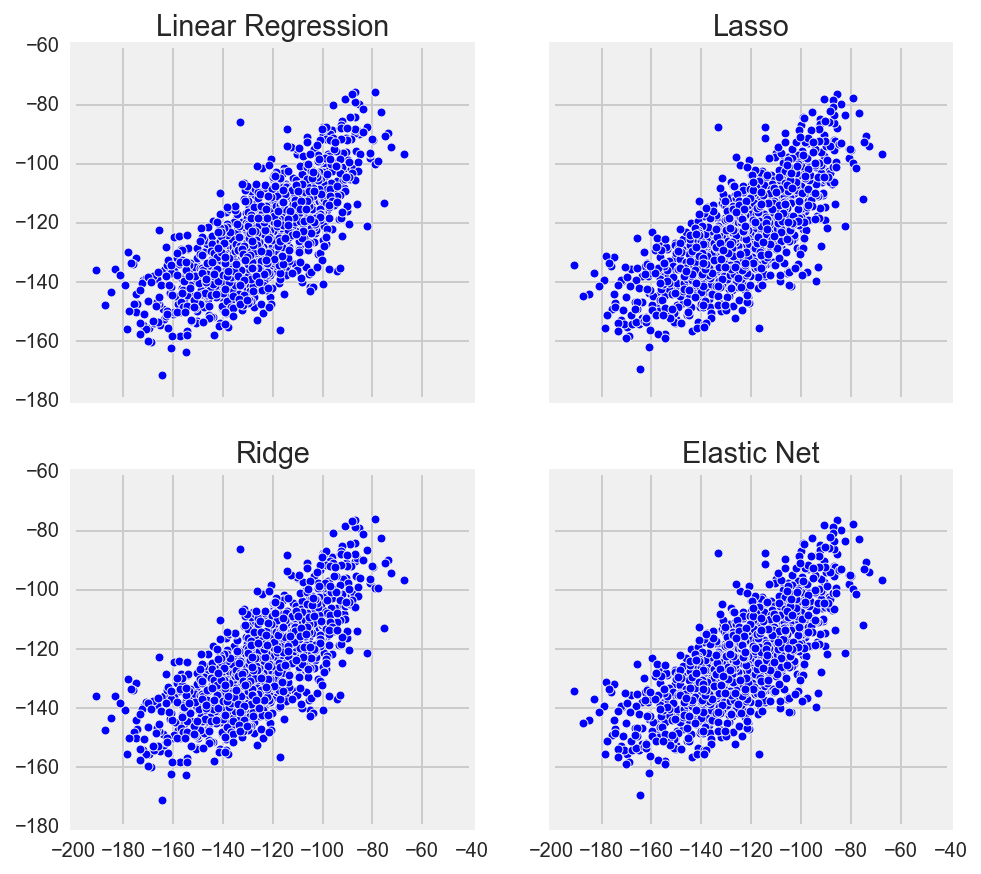


FP Mean
R-squared - LinReg 0.996013938834
R-squared - Lasso 0.995373320913
R-squared - Ridge 0.996012699364
R-squared - ElasticNet 0.995373320913


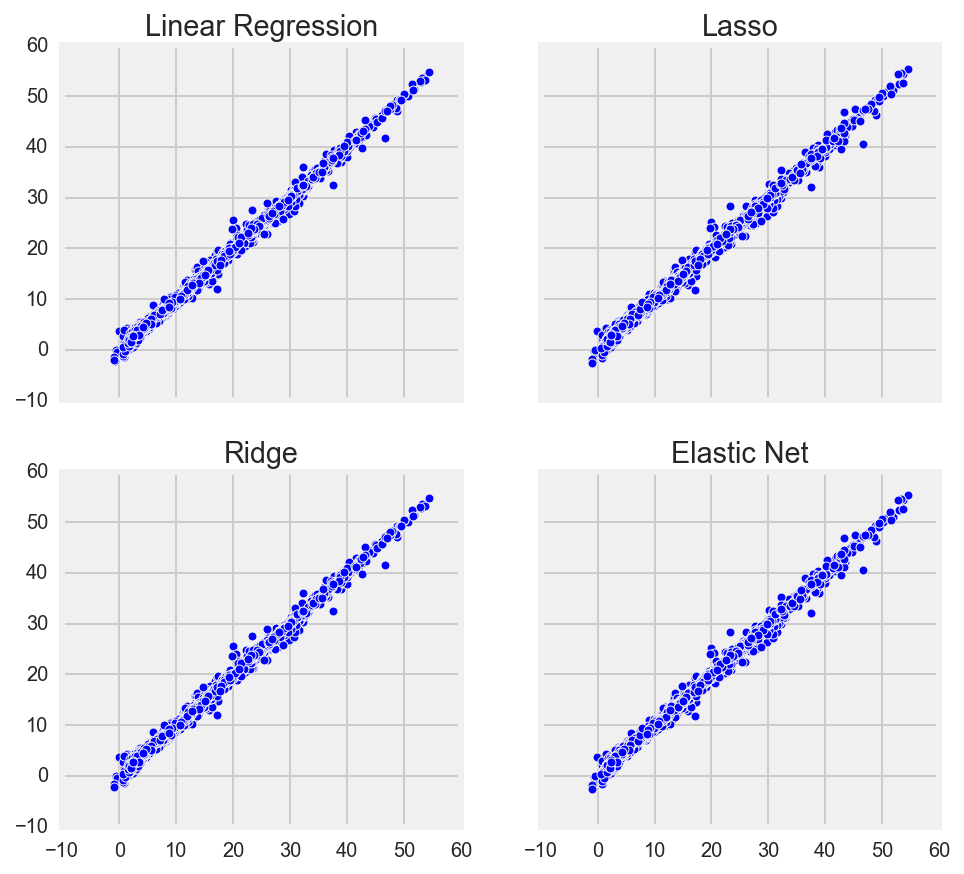


FP STD
R-squared - LinReg 0.777050747318
R-squared - Lasso 0.776849993738
R-squared - Ridge 0.776098912406
R-squared - ElasticNet 0.776849993738


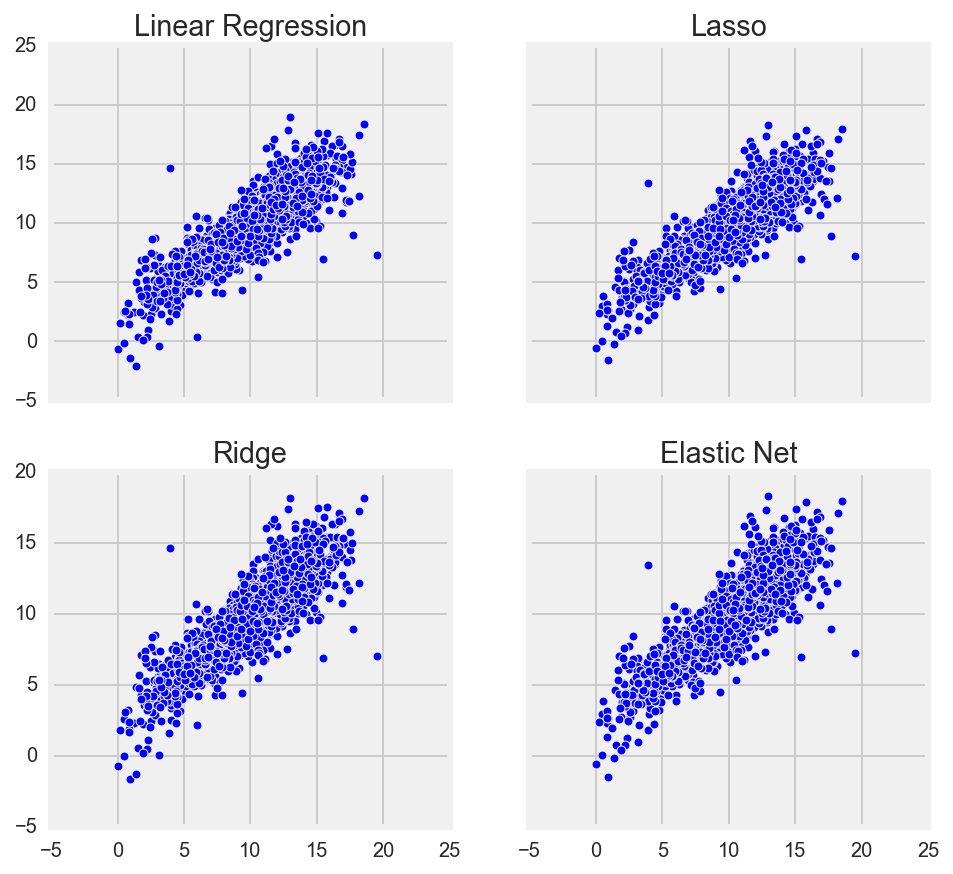


FP Var
R-squared - LinReg 0.728028010562
R-squared - Lasso 0.727724297925
R-squared - Ridge 0.727966627209
R-squared - ElasticNet 0.727724297925


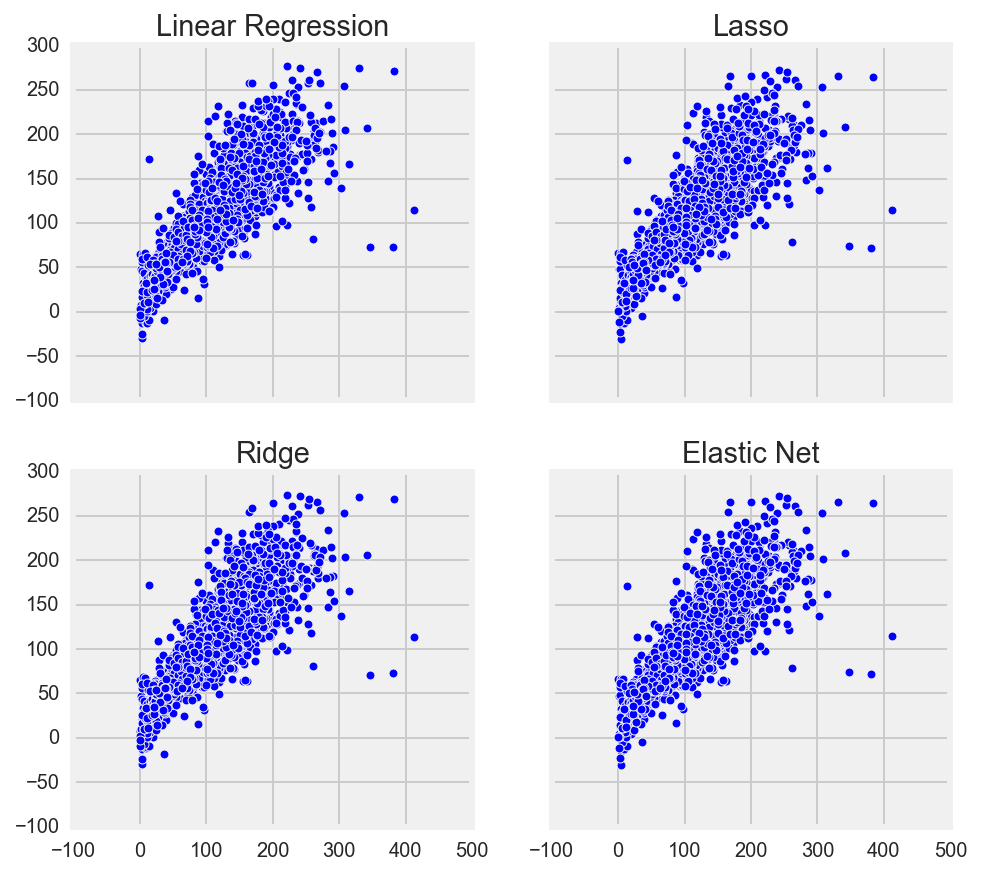

In [69]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7,7))
print 'Agg Rank'
print 'R-squared - LinReg', r2_score(testY_agg_n, prediction_linreg_agg)
print 'R-squared - Lasso', r2_score(testY_agg_n, prediction_lasso_agg)
print 'R-squared - Ridge', r2_score(testY_agg_n, prediction_ridge_agg)
print 'R-squared - ElasticNet', r2_score(testY_agg_n, prediction_en_agg)
ax1.scatter(testY_agg_n, prediction_linreg_agg)
ax2.scatter(testY_agg_n, prediction_lasso_agg)
ax3.scatter(testY_agg_n, prediction_ridge_agg)
ax4.scatter(testY_agg_n, prediction_en_agg)
ax1.set_title('Linear Regression')
ax2.set_title('Lasso')
ax3.set_title('Ridge')
ax4.set_title('Elastic Net')
plt.show()
print '======================================================================'
print 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7,7))
print 'Clutch Rank'
print 'R-squared - LinReg', r2_score(testY_clutch_n, prediction_linreg_clutch)
print 'R-squared - Lasso', r2_score(testY_clutch_n, prediction_lasso_clutch)
print 'R-squared - Ridge', r2_score(testY_clutch_n, prediction_ridge_clutch)
print 'R-squared - ElasticNet', r2_score(testY_clutch_n, prediction_en_clutch)
ax1.scatter(testY_clutch_n, prediction_linreg_clutch)
ax2.scatter(testY_clutch_n, prediction_lasso_clutch)
ax3.scatter(testY_clutch_n, prediction_ridge_clutch)
ax4.scatter(testY_clutch_n, prediction_en_clutch)
ax1.set_title('Linear Regression')
ax2.set_title('Lasso')
ax3.set_title('Ridge')
ax4.set_title('Elastic Net')
plt.show()
print '======================================================================'
print

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7,7))
print 'FP Mean'
print 'R-squared - LinReg', r2_score(testY_fp_mean_n, prediction_linreg_fp_mean)
print 'R-squared - Lasso', r2_score(testY_fp_mean_n, prediction_lasso_fp_mean)
print 'R-squared - Ridge', r2_score(testY_fp_mean_n, prediction_ridge_fp_mean)
print 'R-squared - ElasticNet', r2_score(testY_fp_mean_n, prediction_en_fp_mean)
ax1.scatter(testY_fp_mean_n, prediction_linreg_fp_mean)
ax2.scatter(testY_fp_mean_n, prediction_lasso_fp_mean)
ax3.scatter(testY_fp_mean_n, prediction_ridge_fp_mean)
ax4.scatter(testY_fp_mean_n, prediction_en_fp_mean)
ax1.set_title('Linear Regression')
ax2.set_title('Lasso')
ax3.set_title('Ridge')
ax4.set_title('Elastic Net')
plt.show()
print '======================================================================'
print

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7,7))
print 'FP STD'
print 'R-squared - LinReg', r2_score(testY_fp_std_n, prediction_linreg_fp_std)
print 'R-squared - Lasso', r2_score(testY_fp_std_n, prediction_lasso_fp_std)
print 'R-squared - Ridge', r2_score(testY_fp_std_n, prediction_ridge_fp_std)
print 'R-squared - ElasticNet', r2_score(testY_fp_std_n, prediction_en_fp_std)
ax1.scatter(testY_fp_std_n, prediction_linreg_fp_std)
ax2.scatter(testY_fp_std_n, prediction_lasso_fp_std)
ax3.scatter(testY_fp_std_n, prediction_ridge_fp_std)
ax4.scatter(testY_fp_std_n, prediction_en_fp_std)
ax1.set_title('Linear Regression')
ax2.set_title('Lasso')
ax3.set_title('Ridge')
ax4.set_title('Elastic Net')
plt.show()
print '======================================================================'
print

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7,7))
print 'FP Var'
print 'R-squared - LinReg', r2_score(testY_fp_var_n, prediction_linreg_fp_var)
print 'R-squared - Lasso', r2_score(testY_fp_var_n, prediction_lasso_fp_var)
print 'R-squared - Ridge', r2_score(testY_fp_var_n, prediction_ridge_fp_var)
print 'R-squared - ElasticNet', r2_score(testY_fp_var_n, prediction_en_fp_var)
ax1.scatter(testY_fp_var_n, prediction_linreg_fp_var)
ax2.scatter(testY_fp_var_n, prediction_lasso_fp_var)
ax3.scatter(testY_fp_var_n, prediction_ridge_fp_var)
ax4.scatter(testY_fp_var_n, prediction_en_fp_var)
ax1.set_title('Linear Regression')
ax2.set_title('Lasso')
ax3.set_title('Ridge')
ax4.set_title('Elastic Net')
plt.show()
print '======================================================================'
print

In [70]:
y_game_risk_roc = label_binarize((y_game_risk * -1), classes=[0,1,2,3])
n_classes = y_game_risk_roc.shape[1]

In [71]:
trainX_roc, testX_roc, trainY_roc, testY_roc = train_test_split(X_game_risk_n, y_game_risk_roc, train_size=.75)

In [72]:
onevsall.fit(trainX_roc, trainY_roc)

/Users/edwardlee/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None),
          n_jobs=1)

In [73]:
prediction_ova_game_risk = onevsall.predict_proba(testX_roc)
prediction_ova_df_game_risk = onevsall.decision_function(testX_roc)

Game Risk
R-squared - Logreg:  0.76885319054
R-squared - Lasso:  0.854003642799
R-squared - Ridge:  0.855632135165
R-squared - ElasticNet:  0.854003642799


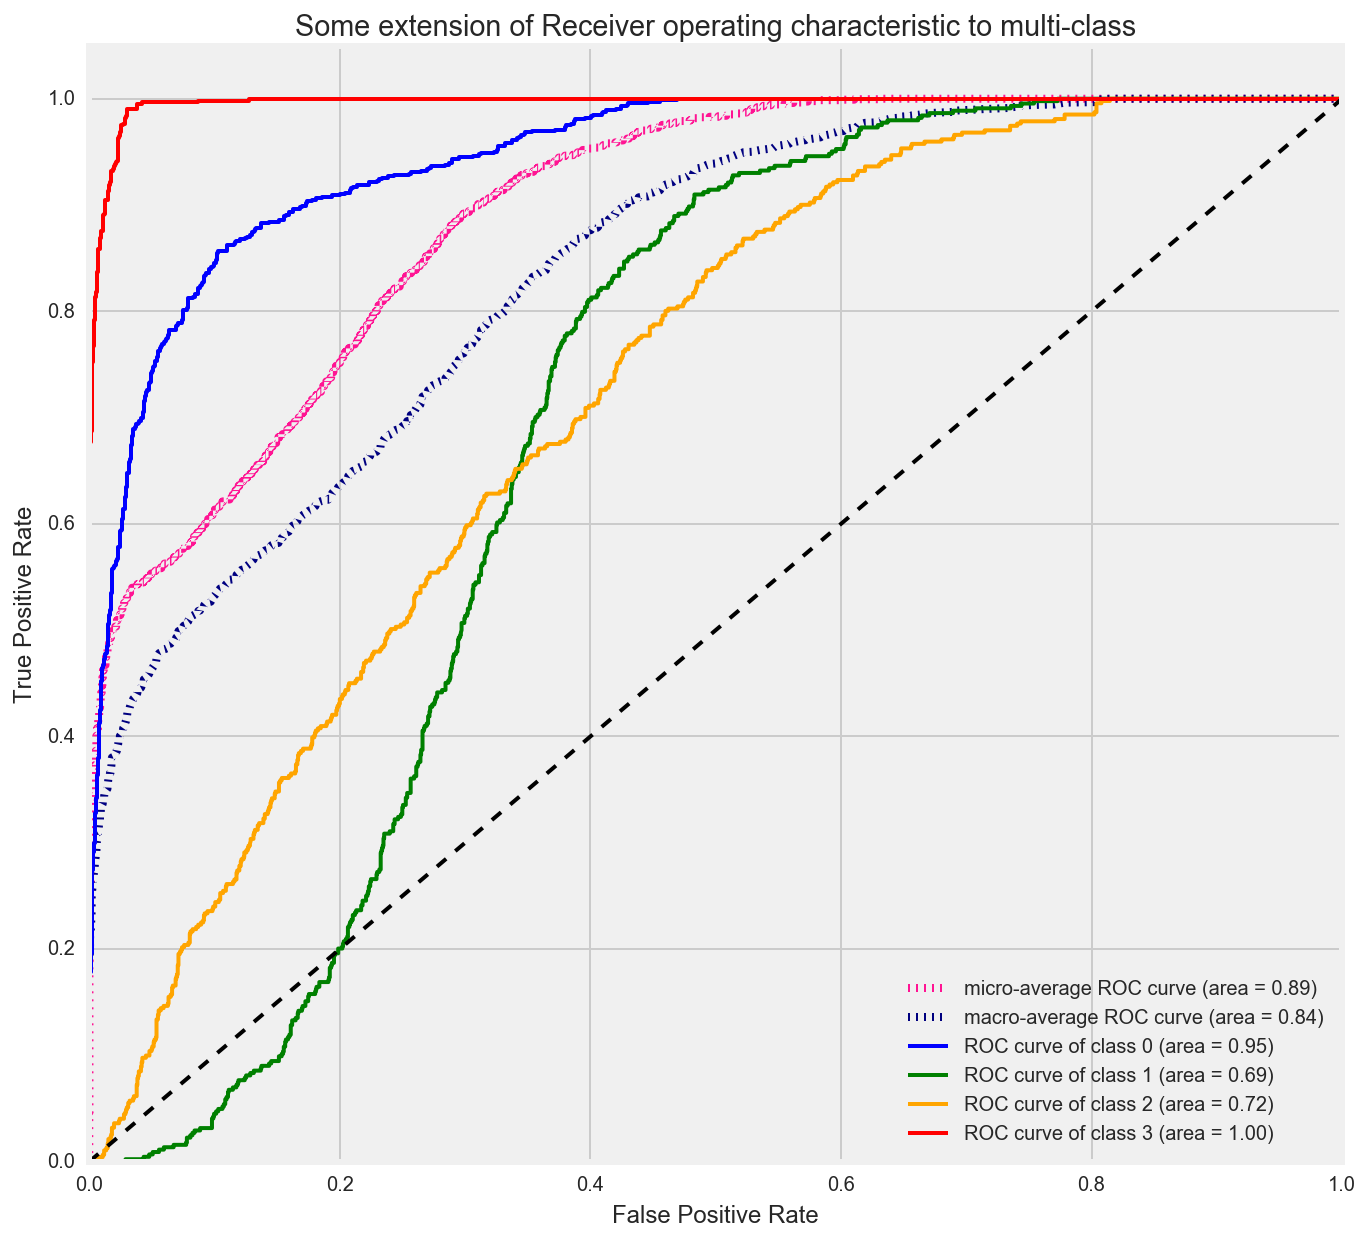

In [244]:
print 'Game Risk'
print 'R-squared - Logreg: ', estimator_logreg_game_risk.score(testX_game_risk_n, testY_game_risk_n)
print 'R-squared - Lasso: ', model_lasso_game_risk.score(testX_game_risk_n, testY_game_risk_n)
print 'R-squared - Ridge: ', model_ridge_game_risk.score(testX_game_risk_n, testY_game_risk_n)
print 'R-squared - ElasticNet: ', model_en_game_risk.score(testX_game_risk_n, testY_game_risk_n)
print '======================================================================'

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testY_roc[:, i], prediction_ova_game_risk[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(testY_roc.ravel(), prediction_ova_df_game_risk.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['blue', 'green', 'orange', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [232]:
print classification_report(testY_game_risk * -1, predict_model_logreg_cv * -1, target_names=["lowrisk", 'caution', 'high_risk', 'danger'])

             precision    recall  f1-score   support

    lowrisk       0.33      0.36      0.34       730
    caution       0.17      0.14      0.16       437
  high_risk       0.20      0.21      0.20       457
     danger       0.26      0.26      0.26       617

avg / total       0.25      0.26      0.26      2241



# ========================================================
# Random Forest Modeling
# ========================================================

In [77]:
# cPickle Agg
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/model_agg.pickle', 'rb') as f:
    rf_model_agg = pickle.load(f)

In [78]:
# cPickle Clutch
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/model_clutch.pickle', 'rb') as f:
    rf_model_clutch = pickle.load(f)

In [79]:
# cPickle Game Risk
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_data/model_game_risk.pickle', 'rb') as f:
    rf_model_game_risk = pickle.load(f)

In [80]:
# cPickle FP Mean
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_test_data/model_fp_mean.pickle', 'rb') as f:
    rf_model_fp_mean = pickle.load(f)

In [81]:
# cPickle FP Std
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_test_data/model_fp_std.pickle', 'rb') as f:
    rf_model_fp_std = pickle.load(f)

In [82]:
# cPickle FP Var
with open('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/code/pickled_test_data/model_fp_var.pickle', 'rb') as f:
    rf_model_fp_var = pickle.load(f)

In [83]:
predict_rf_agg_train = rf_model_agg.predict(trainX_agg)
predict_rf_agg_test = rf_model_agg.predict(testX_agg)

predict_rf_clutch_train = rf_model_clutch.predict(trainX_clutch)
predict_rf_clutch_test = rf_model_clutch.predict(testX_clutch)

predict_rf_fp_mean_train = rf_model_fp_mean.predict(trainX_fp_mean)
predict_rf_fp_mean_test = rf_model_fp_mean.predict(testX_fp_mean)

predict_rf_fp_std_train = rf_model_fp_std.predict(trainX_fp_std)
predict_rf_fp_std_test = rf_model_fp_std.predict(testX_fp_std)

predict_rf_fp_var_train = rf_model_fp_var.predict(trainX_fp_var)
predict_rf_fp_var_test = rf_model_fp_var.predict(testX_fp_var)

predict_rf_game_risk_train = rf_model_game_risk.predict(trainX_game_risk)
predict_rf_game_risk_test = rf_model_game_risk.predict(testX_game_risk)

In [84]:
print 'Agg Rank Best Estimator: ', rf_model_agg.best_estimator_
print 'Clutch Rank Best Estimator: ', rf_model_clutch.best_estimator_
print 'Game Risk Best Estimator: ', rf_model_game_risk.best_estimator_
print 'FP Mean Best Estimator: ', rf_model_fp_mean.best_estimator_
print 'FP Std Best Estimator: ', rf_model_fp_std.best_estimator_
print 'FP Var Best Estimator: ', rf_model_fp_var.best_estimator_
print
print '======================================================'
print
print 'Agg Rank Best Param: ', rf_model_agg.best_params_
print 'Clutch Rank Best Param: ', rf_model_clutch.best_params_
print 'Game Risk Best Param: ', rf_model_game_risk.best_params_
print 'FP Mean Best Param: ', rf_model_fp_mean.best_params_
print 'FP Std Best Param: ', rf_model_fp_std.best_params_
print 'FP Var Best Param: ', rf_model_fp_var.best_params_
print
print '======================================================'
print
print 'Agg Rank MSE train: ', mean_squared_error(trainY_agg, predict_rf_agg_train)
print 'Agg Rank MSE test: ', mean_squared_error(testY_agg, predict_rf_agg_test)
print 'Agg Rank MSE baseline: ', mean_squared_error(y_agg, np.tile(np.mean(y_agg), len(y_agg)))
print 
print 'Clutch Rank MSE train: ', mean_squared_error(trainY_clutch, predict_rf_clutch_train)
print 'Clutch Rank MSE test: ', mean_squared_error(testY_clutch, predict_rf_clutch_test)
print 'Clutch Rank MSE baseline: ', mean_squared_error(y_clutch, np.tile(np.mean(y_clutch), len(y_clutch)))
print
print 'FP Mean MSE train: ', mean_squared_error(trainY_fp_mean, predict_rf_fp_mean_train)
print 'FP Mean MSE test: ', mean_squared_error(testY_fp_mean, predict_rf_fp_mean_test)
print 'FP Mean MSE baseline: ', mean_squared_error(y_fp_mean, np.tile(np.mean(y_fp_mean), len(y_fp_mean)))
print
print 'FP Std MSE train: ', mean_squared_error(trainY_fp_std, predict_rf_fp_std_train)
print 'FP Std MSE test: ', mean_squared_error(testY_fp_std, predict_rf_fp_std_test)
print 'FP Std MSE baseline: ', mean_squared_error(y_fp_std, np.tile(np.mean(y_fp_std), len(y_fp_std)))
print
print 'FP Var MSE train: ', mean_squared_error(trainY_fp_var, predict_rf_fp_var_train)
print 'FP Var MSE test: ', mean_squared_error(testY_fp_var, predict_rf_fp_var_test)
print 'FP Var MSE baseline: ', mean_squared_error(y_fp_var, np.tile(np.mean(y_fp_var), len(y_fp_var)))
print
print 'Game Risk MSE train: ', mean_squared_error(trainY_game_risk, predict_rf_game_risk_train)
print 'Game Risk MSE test: ', mean_squared_error(testY_game_risk, predict_rf_game_risk_test)
print 'Game Risk MSE baseline: ', mean_squared_error(y_game_risk, np.tile(np.mean(y_game_risk), len(y_game_risk)))
print
print '======================================================'
print 
print 'Agg Rank RMSE train: ', np.sqrt(mean_squared_error(trainY_agg, predict_rf_agg_train))
print 'Agg Rank RMSE test: ', np.sqrt(mean_squared_error(testY_agg, predict_rf_agg_test))
print 'Agg Rank RMSE baseline: ', np.sqrt(mean_squared_error(y_agg, np.tile(np.mean(y_agg), len(y_agg))))
print
print 'Clutch Rank RMSE train: ', np.sqrt(mean_squared_error(trainY_clutch, predict_rf_clutch_train))
print 'Clutch Rank RMSE test: ', np.sqrt(mean_squared_error(testY_clutch, predict_rf_clutch_test))
print 'Clutch Rank RMSE baseline: ', np.sqrt(mean_squared_error(y_clutch, np.tile(np.mean(y_clutch), len(y_clutch))))
print
print 'FP Mean RMSE train: ', np.sqrt(mean_squared_error(trainY_fp_mean, predict_rf_fp_mean_train))
print 'FP Mean RMSE test: ', np.sqrt(mean_squared_error(testY_fp_mean, predict_rf_fp_mean_test))
print 'FP Mean RMSE baseline: ', np.sqrt(mean_squared_error(y_fp_mean, np.tile(np.mean(y_fp_mean), len(y_fp_mean))))
print
print 'FP Std RMSE train: ', np.sqrt(mean_squared_error(trainY_fp_std, predict_rf_fp_std_train))
print 'FP Std RMSE test: ', np.sqrt(mean_squared_error(testY_fp_std, predict_rf_fp_std_test))
print 'FP Std RMSE baseline: ', np.sqrt(mean_squared_error(y_fp_std, np.tile(np.mean(y_fp_std), len(y_fp_std))))
print
print 'FP Var RMSE train: ', np.sqrt(mean_squared_error(trainY_fp_var, predict_rf_fp_var_train))
print 'FP Var RMSE test: ', np.sqrt(mean_squared_error(testY_fp_var, predict_rf_fp_var_test))
print 'FP Var RMSE baseline: ', np.sqrt(mean_squared_error(y_fp_var, np.tile(np.mean(y_fp_var), len(y_fp_var))))
print
print 'Game Risk RMSE train: ', np.sqrt(mean_squared_error(trainY_game_risk, predict_rf_game_risk_train))
print 'Game Risk RMSE test: ', np.sqrt(mean_squared_error(testY_game_risk, predict_rf_game_risk_test))
print 'Game Risk RMSE baseline: ', np.sqrt(mean_squared_error(y_game_risk, np.tile(np.mean(y_game_risk), len(y_game_risk))))
print
print '======================================================'
print
print 'Agg Rank R^2 train: ', r2_score(trainY_agg, predict_rf_agg_train)
print 'Agg Rank R^2 test: ', r2_score(testY_agg, predict_rf_agg_test)
print
print 'Clutch Rank R^2 train: ', r2_score(trainY_clutch, predict_rf_clutch_train)
print 'Clutch Rank R^2 test: ', r2_score(testY_clutch, predict_rf_clutch_test)
print
print 'FP Mean R^2 train: ', r2_score(trainY_fp_mean, predict_rf_fp_mean_train)
print 'FP Mean R^2 test: ', r2_score(testY_fp_mean, predict_rf_fp_mean_test)
print
print 'FP Std R^2 train: ', r2_score(trainY_fp_std, predict_rf_fp_std_train)
print 'FP Std R^2 test: ', r2_score(testY_fp_std, predict_rf_fp_std_test)
print
print 'FP Var R^2 train: ', r2_score(trainY_fp_var, predict_rf_fp_var_train)
print 'FP Var R^2 test: ', r2_score(testY_fp_var, predict_rf_fp_var_test)
print
print 'Game Risk R^2 train: ', r2_score(trainY_game_risk, predict_rf_game_risk_train)
print 'Game Risk R^2 test: ', r2_score(testY_game_risk, predict_rf_game_risk_test)
print
print '======================================================'

Agg Rank Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Clutch Rank Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Game Risk Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
       

In [85]:
print classification_report(testY_game_risk * -1, predict_rf_game_risk_test * -1, target_names=["lowrisk", 'caution', 'high_risk', 'danger'])

             precision    recall  f1-score   support

    lowrisk       1.00      0.97      0.99       730
    caution       0.97      0.97      0.97       437
  high_risk       0.95      0.97      0.96       457
     danger       0.98      1.00      0.99       617

avg / total       0.98      0.98      0.98      2241



# ========================================================
# Predictions - FULL Dataset
### Create predictions with all my target variables
# ========================================================

In [104]:
predict_columns_agg = [u'PCT_FGM', u'PCT_FGA', u'PCT_FG3M', u'PCT_FG3A',
       u'PCT_FTM', u'PCT_FTA', u'PCT_DREB', u'PCT_REB',
       u'PCT_AST', u'PCT_TOV', u'PCT_STL', u'PCT_BLKA', 
       u'PCT_PFD', u'PCT_PTS', u'PCT_FGA_2PT', u'PCT_FGA_3PT', u'PCT_PTS_2PT', u'PCT_PTS_2PT_MR',
       u'PCT_PTS_3PT', u'PCT_PTS_FB', u'PCT_PTS_FT', u'PCT_PTS_OFF_TOV',
       u'PCT_UAST_2PM', u'PCT_AST_3PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM',
       u'OFF_RATING', u'NET_RATING', u'AST_PCT', u'AST_TO',
       u'AST_RATIO', u'DREB_PCT', u'REB_PCT', u'TM_TOV_PCT',
       u'EFG_PCT', u'TS_PCT', u'USG_PCT', u'PIE', u'FGM_PG',
       u'GP', u'W', u'L', u'MIN', u'FTM', u'FTA',
       u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK',
       u'BLKA', u'PF', u'PFD', u'PTS', u'PLUS_MINUS', u'DD2', u'TD3',
       u'PTS_OFF_TOV', u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_PAINT',
       u'OPP_PTS_OFF_TOV', u'OPP_PTS_2ND_CHANCE', u'OPP_PTS_FB',
       u'OPP_PTS_PAINT', u'FGM_less_than_5_ft',
       u'FGA_less_than_5_ft', u'FGM_5-9_ft', u'FGA_5-9_ft', u'FGM_10-14_ft', u'FGA_10-14_ft', u'FGM_15-19_ft', 
       u'FGA_15-19_ft', u'FGM_20-24_ft', u'FGA_20-24_ft', u'FGM_25-29_ft', u'FGA_25-29_ft', 
       u'OPP_FGM_less_than_5_ft', u'OPP_FGA_less_than_5_ft', u'OPP_FGM_5-9_ft', u'OPP_FGA_5-9_ft', 
       u'OPP_FGM_10-14_ft', u'OPP_FGA_10-14_ft', u'OPP_FGM_15-19_ft', u'OPP_FGA_15-19_ft', u'OPP_FGM_20-24_ft', 
       u'OPP_FGA_20-24_ft', u'OPP_FGM_25-29_ft', u'OPP_FGA_25-29_ft']

In [105]:
predict_columns_clutch = [u'PCT_FGM', u'PCT_FGA', u'PCT_FG3A',
       u'PCT_FTM', u'PCT_FTA', u'PCT_DREB', u'PCT_REB',
       u'PCT_AST', u'PCT_TOV', u'PCT_STL', u'PCT_BLKA', 
       u'PCT_PFD', u'PCT_PTS', u'PCT_FGA_2PT', u'PCT_PTS_2PT', u'PCT_PTS_2PT_MR',
       u'PCT_PTS_FB', u'PCT_PTS_FT', u'PCT_PTS_OFF_TOV',
       u'PCT_UAST_2PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM',
       u'OFF_RATING', u'NET_RATING', u'AST_PCT', u'AST_TO',
       u'AST_RATIO', u'DREB_PCT', u'REB_PCT',
       u'TS_PCT', u'USG_PCT', u'PIE', u'FGM_PG',
       u'W', u'MIN', u'FTM', u'FTA',
       u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK',
       u'BLKA', u'PF', u'PFD', u'PTS', u'PLUS_MINUS', u'DD2', u'TD3',
       u'PTS_OFF_TOV', u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_PAINT',
       u'OPP_PTS_OFF_TOV', u'OPP_PTS_2ND_CHANCE', u'OPP_PTS_FB',
       u'OPP_PTS_PAINT', u'FGM_less_than_5_ft',
       u'FGA_less_than_5_ft', u'FGM_5-9_ft', u'FGA_5-9_ft', u'FGM_10-14_ft', u'FGA_10-14_ft', u'FGM_15-19_ft', 
       u'FGA_15-19_ft', u'FGM_20-24_ft', u'FGA_20-24_ft', u'FGM_25-29_ft', u'FGA_25-29_ft', 
       u'OPP_FGM_less_than_5_ft', u'OPP_FGA_less_than_5_ft', u'OPP_FGM_5-9_ft', u'OPP_FGA_5-9_ft', 
       u'OPP_FGM_10-14_ft', u'OPP_FGA_10-14_ft', u'OPP_FGM_15-19_ft', u'OPP_FGA_15-19_ft', u'OPP_FGM_20-24_ft', 
       u'OPP_FGA_20-24_ft', u'OPP_FGM_25-29_ft', u'OPP_FGA_25-29_ft']

In [106]:
predict_columns_risk = [u'PCT_FGM', u'PCT_FGA', u'PCT_FG3M', u'PCT_FG3A',
       u'PCT_FTM', u'PCT_FTA', u'PCT_DREB', 
       u'PCT_AST', u'PCT_STL', 
       u'PCT_PFD', u'PCT_PTS', u'PCT_FGA_3PT', u'PCT_PTS_2PT_MR',
       u'PCT_PTS_3PT', u'PCT_PTS_FB', u'PCT_PTS_OFF_TOV',
       u'PCT_UAST_2PM', u'PCT_AST_3PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM',
       u'OFF_RATING', u'NET_RATING', u'AST_PCT', u'AST_TO',
       u'AST_RATIO', u'DREB_PCT',
       u'EFG_PCT', u'TS_PCT', u'USG_PCT', u'PIE', u'FGM_PG',
       u'GP', u'W', u'L', u'MIN', u'FTM', u'FTA',
       u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK',
       u'BLKA', u'PF', u'PFD', u'PTS', u'PLUS_MINUS', u'DD2', u'TD3',
       u'PTS_OFF_TOV', u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_PAINT',
       u'OPP_PTS_OFF_TOV', u'OPP_PTS_2ND_CHANCE', u'OPP_PTS_FB',
       u'OPP_PTS_PAINT', u'FGM_less_than_5_ft',
       u'FGA_less_than_5_ft', u'FGM_5-9_ft', u'FGA_5-9_ft', u'FGM_10-14_ft', u'FGA_10-14_ft', u'FGM_15-19_ft', 
       u'FGA_15-19_ft', u'FGM_20-24_ft', u'FGA_20-24_ft', u'FGM_25-29_ft', u'FGA_25-29_ft', 
       u'OPP_FGM_less_than_5_ft', u'OPP_FGA_less_than_5_ft', u'OPP_FGM_5-9_ft', u'OPP_FGA_5-9_ft', 
       u'OPP_FGM_10-14_ft', u'OPP_FGA_10-14_ft', u'OPP_FGM_15-19_ft', u'OPP_FGA_15-19_ft', u'OPP_FGM_20-24_ft', 
       u'OPP_FGA_20-24_ft', u'OPP_FGM_25-29_ft', u'OPP_FGA_25-29_ft']

In [107]:
predict_columns_fp_mean = [u'PCT_FGM', u'PCT_FGA', u'PCT_FG3M', u'PCT_FG3A',
       u'PCT_FTM', u'PCT_FTA', u'PCT_DREB', u'PCT_REB',
       u'PCT_AST', u'PCT_TOV', u'PCT_STL', u'PCT_BLKA', 
       u'PCT_PFD', u'PCT_PTS', u'PCT_FGA_2PT', u'PCT_PTS_2PT', u'PCT_PTS_2PT_MR',
       u'PCT_PTS_FB', u'PCT_PTS_FT',
       u'PCT_UAST_2PM', u'PCT_AST_3PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM',
       u'OFF_RATING', u'NET_RATING', u'AST_PCT', u'AST_TO',
       u'AST_RATIO', u'DREB_PCT', u'REB_PCT',
       u'EFG_PCT', u'TS_PCT', u'USG_PCT', u'PIE', u'FGM_PG',
       u'GP', u'W', u'L', u'MIN', u'FTM', u'FTA',
       u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK',
       u'BLKA', u'PF', u'PFD', u'PTS', u'PLUS_MINUS', u'DD2', u'TD3',
       u'PTS_OFF_TOV', u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_PAINT',
       u'OPP_PTS_OFF_TOV', u'OPP_PTS_2ND_CHANCE', u'OPP_PTS_FB',
       u'OPP_PTS_PAINT', u'FGM_less_than_5_ft',
       u'FGA_less_than_5_ft', u'FGM_5-9_ft', u'FGA_5-9_ft', u'FGM_10-14_ft', u'FGA_10-14_ft', u'FGM_15-19_ft', 
       u'FGA_15-19_ft', u'FGM_20-24_ft', u'FGA_20-24_ft', u'FGM_25-29_ft', u'FGA_25-29_ft', 
       u'OPP_FGM_less_than_5_ft', u'OPP_FGA_less_than_5_ft', u'OPP_FGM_5-9_ft', u'OPP_FGA_5-9_ft', 
       u'OPP_FGM_10-14_ft', u'OPP_FGA_10-14_ft', u'OPP_FGM_15-19_ft', u'OPP_FGA_15-19_ft', u'OPP_FGM_20-24_ft', 
       u'OPP_FGA_20-24_ft', u'OPP_FGM_25-29_ft', u'OPP_FGA_25-29_ft']

In [108]:
predict_columns_fp_std = [u'PCT_FGM', u'PCT_FGA', u'PCT_FG3M', u'PCT_FG3A',
       u'PCT_FTM', u'PCT_FTA', u'PCT_DREB',
       u'PCT_AST', u'PCT_TOV', u'PCT_STL', u'PCT_BLKA', 
       u'PCT_PFD', u'PCT_PTS', u'PCT_FGA_3PT',
       u'PCT_PTS_3PT', u'PCT_PTS_FB', u'PCT_PTS_FT', u'PCT_PTS_OFF_TOV',
       u'PCT_UAST_2PM', u'PCT_AST_3PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM',
       u'OFF_RATING', u'NET_RATING', u'AST_PCT', u'AST_TO',
       u'AST_RATIO', u'DREB_PCT', u'REB_PCT',
       u'EFG_PCT', u'TS_PCT', u'USG_PCT', u'PIE', u'FGM_PG',
       u'GP', u'W', u'L', u'MIN', u'FTM', u'FTA',
       u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK',
       u'BLKA', u'PF', u'PFD', u'PTS', u'DD2', u'TD3',
       u'PTS_OFF_TOV', u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_PAINT',
       u'OPP_PTS_OFF_TOV', u'OPP_PTS_2ND_CHANCE', u'OPP_PTS_FB',
       u'OPP_PTS_PAINT', u'FGM_less_than_5_ft',
       u'FGA_less_than_5_ft', u'FGM_5-9_ft', u'FGA_5-9_ft', u'FGM_10-14_ft', u'FGA_10-14_ft', u'FGM_15-19_ft', 
       u'FGA_15-19_ft', u'FGM_20-24_ft', u'FGA_20-24_ft', u'FGM_25-29_ft', u'FGA_25-29_ft', 
       u'OPP_FGM_less_than_5_ft', u'OPP_FGA_less_than_5_ft', u'OPP_FGM_5-9_ft', u'OPP_FGA_5-9_ft', 
       u'OPP_FGM_10-14_ft', u'OPP_FGA_10-14_ft', u'OPP_FGM_15-19_ft', u'OPP_FGA_15-19_ft', u'OPP_FGM_20-24_ft', 
       u'OPP_FGA_20-24_ft', u'OPP_FGM_25-29_ft', u'OPP_FGA_25-29_ft']

In [109]:
predict_columns_fp_var = [u'PCT_FGM', u'PCT_FGA', u'PCT_FG3M', u'PCT_FG3A',
       u'PCT_FTM', u'PCT_FTA', u'PCT_DREB',
       u'PCT_AST', u'PCT_TOV', u'PCT_STL', u'PCT_BLKA', 
       u'PCT_PFD', u'PCT_PTS', u'PCT_FGA_3PT',
       u'PCT_PTS_3PT', u'PCT_PTS_FB', u'PCT_PTS_FT', u'PCT_PTS_OFF_TOV',
       u'PCT_UAST_2PM', u'PCT_AST_3PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM',
       u'OFF_RATING', u'NET_RATING', u'AST_PCT', u'AST_TO',
       u'AST_RATIO', u'DREB_PCT', u'REB_PCT',
       u'EFG_PCT', u'TS_PCT', u'USG_PCT', u'PIE', u'FGM_PG',
       u'GP', u'W', u'L', u'MIN', u'FTM', u'FTA',
       u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK',
       u'BLKA', u'PF', u'PFD', u'PTS', u'DD2', u'TD3',
       u'PTS_OFF_TOV', u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_PAINT',
       u'OPP_PTS_OFF_TOV', u'OPP_PTS_2ND_CHANCE', u'OPP_PTS_FB',
       u'OPP_PTS_PAINT', u'FGM_less_than_5_ft',
       u'FGA_less_than_5_ft', u'FGM_5-9_ft', u'FGA_5-9_ft', u'FGM_10-14_ft', u'FGA_10-14_ft', u'FGM_15-19_ft', 
       u'FGA_15-19_ft', u'FGM_20-24_ft', u'FGA_20-24_ft', u'FGM_25-29_ft', u'FGA_25-29_ft', 
       u'OPP_FGM_less_than_5_ft', u'OPP_FGA_less_than_5_ft', u'OPP_FGM_5-9_ft', u'OPP_FGA_5-9_ft', 
       u'OPP_FGM_10-14_ft', u'OPP_FGA_10-14_ft', u'OPP_FGM_15-19_ft', u'OPP_FGA_15-19_ft', u'OPP_FGM_20-24_ft', 
       u'OPP_FGA_20-24_ft', u'OPP_FGM_25-29_ft', u'OPP_FGA_25-29_ft']

In [110]:
df_predict_model = pd.read_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/completed/complete_all.csv')
df_predict_model_std_var = pd.read_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/completed/complete_all.csv')

In [111]:
df_predict_model.drop('Unnamed: 0', axis=1,inplace=True)
df_predict_model_std_var.drop('Unnamed: 0', axis=1,inplace=True)

# Drop all NaN values from player name, team abbreviation and age
df_predict_model.dropna(subset=['PLAYER_NAME', 'TEAM_ABBREVIATION', 'AGE'], how='all', inplace=True)
df_predict_model_std_var.dropna(subset=['PLAYER_NAME', 'TEAM_ABBREVIATION', 'AGE'], how='all', inplace=True)

In [112]:
# Dropping clutch rank since it will drop 50% of the columns
df_predict_model.drop('clutch_agg_rank', inplace=True, axis=1)
df_predict_model_std_var.drop('clutch_agg_rank', inplace=True, axis=1)

In [113]:
# Features that were previously removed from creating dummy variables
df_predict_model.drop(['FGM_30-34_ft', 'FGA_30-34_ft', 'FG_PCT_30-34_ft',
              'FGM_35-39_ft', 'FGA_35-39_ft', 'FG_PCT_35-39_ft',
              'FGM_40+_ft', 'FGA_40+_ft', 'FG_PCT_40+_ft',
              'OPP_FGM_30-34_ft', 'OPP_FGA_30-34_ft', 'OPP_FG_PCT_30-34_ft',
              'OPP_FGM_35-39_ft', 'OPP_FGA_35-39_ft', 'OPP_FG_PCT_35-39_ft',
              'OPP_FGM_40+_ft', 'OPP_FGA_40+_ft', 'OPP_FG_PCT_40+_ft',], axis=1, inplace=True)

In [115]:
# Features that were previously removed from creating dummy variables
df_predict_model_std_var.drop(['FGM_30-34_ft', 'FGA_30-34_ft', 'FG_PCT_30-34_ft',
              'FGM_35-39_ft', 'FGA_35-39_ft', 'FG_PCT_35-39_ft',
              'FGM_40+_ft', 'FGA_40+_ft', 'FG_PCT_40+_ft',
              'OPP_FGM_30-34_ft', 'OPP_FGA_30-34_ft', 'OPP_FG_PCT_30-34_ft',
              'OPP_FGM_35-39_ft', 'OPP_FGA_35-39_ft', 'OPP_FG_PCT_35-39_ft',
              'OPP_FGM_40+_ft', 'OPP_FGA_40+_ft', 'OPP_FG_PCT_40+_ft',], axis=1, inplace=True)

In [116]:
print df_predict_model.shape, df_predict_model_std_var.shape

(9075, 228) (9075, 228)


In [117]:
df_predict_model.dropna(inplace=True)
df_predict_model_std_var.dropna(inplace=True)

In [118]:
print df_predict_model.shape, df_predict_model_std_var.shape

(8962, 228) (8962, 228)


In [258]:
df_predict_2015 = df_predict_model[df_predict_model.SEASON == '2015-16']
df_predict_2014 = df_predict_model[df_predict_model.SEASON == '2014-15']
df_predict_2013 = df_predict_model[df_predict_model.SEASON == '2013-14']

In [120]:
mean_game_risk = pd.DataFrame(df_predict_model.groupby(['PLAYER_ID'])['game_risk'].mean().reset_index())

In [259]:
# Creating new game_risk column by game_risk mean per player
df_predict_2015.drop('game_risk', axis=1, inplace=True)
df_predict_2014.drop('game_risk', axis=1, inplace=True)
df_predict_2013.drop('game_risk', axis=1, inplace=True)

/Users/edwardlee/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/edwardlee/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/edwardlee/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [260]:
df_predict_2015 = df_predict_2015.merge(mean_game_risk, on='PLAYER_ID', how='left')
df_predict_2014 = df_predict_2014.merge(mean_game_risk, on='PLAYER_ID', how='left')
df_predict_2013 = df_predict_2013.merge(mean_game_risk, on='PLAYER_ID', how='left')

In [261]:
# Setup respective dataframes for each model to predict on
df_predict_agg_15 = df_predict_2015[predict_columns_agg]
df_predict_game_risk_15 = df_predict_2015[predict_columns_risk]
df_predict_fp_mean_15 = df_predict_2015[predict_columns_fp_mean]
df_predict_fp_std_15 = df_predict_2015[predict_columns_fp_std]
df_predict_fp_var_15 = df_predict_2015[predict_columns_fp_var]
df_predict_clutch_agg_15 = df_predict_2015[predict_columns_clutch]

In [262]:
# Setup respective dataframes for each model to predict on
df_predict_agg_14 = df_predict_2014[predict_columns_agg]
df_predict_game_risk_14 = df_predict_2014[predict_columns_risk]
df_predict_fp_mean_14 = df_predict_2014[predict_columns_fp_mean]
df_predict_fp_std_14 = df_predict_2014[predict_columns_fp_std]
df_predict_fp_var_14 = df_predict_2014[predict_columns_fp_var]
df_predict_clutch_agg_14 = df_predict_2014[predict_columns_clutch]

In [263]:
# Setup respective dataframes for each model to predict on
df_predict_agg_13 = df_predict_2013[predict_columns_agg]
df_predict_game_risk_13 = df_predict_2013[predict_columns_risk]
df_predict_fp_mean_13 = df_predict_2013[predict_columns_fp_mean]
df_predict_fp_std_13 = df_predict_2013[predict_columns_fp_std]
df_predict_fp_var_13 = df_predict_2013[predict_columns_fp_var]
df_predict_clutch_agg_13 = df_predict_2013[predict_columns_clutch]

In [264]:
df_predict_2015['agg_rank_score'] = rf_model_agg.predict(df_predict_agg_15)
df_predict_2015['game_risk_score'] = rf_model_game_risk.predict(df_predict_game_risk_15)
df_predict_2015['fp_mean_score'] = rf_model_fp_mean.predict(df_predict_fp_mean_15)
df_predict_2015['fp_std_score'] = rf_model_fp_std.predict(df_predict_fp_std_15)
df_predict_2015['fp_var_score'] = rf_model_fp_var.predict(df_predict_fp_var_15)
df_predict_2015['clutch_rank_score'] = rf_model_clutch.predict(df_predict_clutch_agg_15)

In [265]:
df_predict_2014['agg_rank_score'] = rf_model_agg.predict(df_predict_agg_14)
df_predict_2014['game_risk_score'] = rf_model_game_risk.predict(df_predict_game_risk_14)
df_predict_2014['fp_mean_score'] = rf_model_fp_mean.predict(df_predict_fp_mean_14)
df_predict_2014['fp_std_score'] = rf_model_fp_std.predict(df_predict_fp_std_14)
df_predict_2014['fp_var_score'] = rf_model_fp_var.predict(df_predict_fp_var_14)
df_predict_2014['clutch_rank_score'] = rf_model_clutch.predict(df_predict_clutch_agg_14)

In [266]:
df_predict_2013['agg_rank_score'] = rf_model_agg.predict(df_predict_agg_13)
df_predict_2013['game_risk_score'] = rf_model_game_risk.predict(df_predict_game_risk_13)
df_predict_2013['fp_mean_score'] = rf_model_fp_mean.predict(df_predict_fp_mean_13)
df_predict_2013['fp_std_score'] = rf_model_fp_std.predict(df_predict_fp_std_13)
df_predict_2013['fp_var_score'] = rf_model_fp_var.predict(df_predict_fp_var_13)
df_predict_2013['clutch_rank_score'] = rf_model_clutch.predict(df_predict_clutch_agg_13)

In [268]:
my_rank_2015 = df_predict_2015[['PLAYER_NAME', 'fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score']].sort_values(['fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score'], ascending=False).reset_index(drop=True)
my_rank_2015.to_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/my_rank_2015.csv')

In [269]:
my_rank_2014 = df_predict_2014[['PLAYER_NAME', 'fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score']].sort_values(['fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score'], ascending=False).reset_index(drop=True)
my_rank_2014.to_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/my_rank_2014.csv')

In [270]:
my_rank_2013 = df_predict_2013[['PLAYER_NAME', 'fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score']].sort_values(['fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score'], ascending=False).reset_index(drop=True)
my_rank_2013.to_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/my_rank_2013.csv')

# ========================================================
# Predictions - Based off Clutch Dataset
### Create predictions with all my target variables
# ========================================================

In [144]:
df_predict_model_clutch = pd.read_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/completed/complete_all.csv')

In [145]:
df_predict_model_clutch.drop('Unnamed: 0', axis=1,inplace=True)
df_predict_model_clutch.dropna(subset=['PLAYER_NAME', 'TEAM_ABBREVIATION', 'AGE'], how='all', inplace=True)

In [146]:
# Features that were previously removed from creating dummy variables
df_predict_model_clutch.drop(['FGM_30-34_ft', 'FGA_30-34_ft', 'FG_PCT_30-34_ft',
              'FGM_35-39_ft', 'FGA_35-39_ft', 'FG_PCT_35-39_ft',
              'FGM_40+_ft', 'FGA_40+_ft', 'FG_PCT_40+_ft',
              'OPP_FGM_30-34_ft', 'OPP_FGA_30-34_ft', 'OPP_FG_PCT_30-34_ft',
              'OPP_FGM_35-39_ft', 'OPP_FGA_35-39_ft', 'OPP_FG_PCT_35-39_ft',
              'OPP_FGM_40+_ft', 'OPP_FGA_40+_ft', 'OPP_FG_PCT_40+_ft',], axis=1, inplace=True)

In [147]:
print df_predict_model_clutch.shape

(9075, 229)


In [148]:
df_predict_model_clutch.dropna(inplace=True)

In [149]:
print df_predict_model_clutch.shape

(4940, 229)


In [150]:
df_predict_2015_clutch = df_predict_model_clutch[df_predict_model_clutch.SEASON == '2015-16']
df_predict_2014_clutch = df_predict_model_clutch[df_predict_model_clutch.SEASON == '2014-15']
df_predict_2013_clutch = df_predict_model_clutch[df_predict_model_clutch.SEASON == '2013-14']
df_predict_2012_clutch = df_predict_model_clutch[df_predict_model_clutch.SEASON == '2012-13']

In [151]:
print df_predict_2015_clutch.shape, df_predict_2014_clutch.shape, df_predict_2013_clutch.shape, df_predict_2012_clutch.shape

(258, 229) (263, 229) (250, 229) (254, 229)


In [152]:
df_predict_2015_clutch.drop('game_risk', axis=1, inplace=True)
df_predict_2014_clutch.drop('game_risk', axis=1, inplace=True)
df_predict_2013_clutch.drop('game_risk', axis=1, inplace=True)
df_predict_2012_clutch.drop('game_risk', axis=1, inplace=True)

/Users/edwardlee/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/edwardlee/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/edwardlee/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instanc

In [153]:
df_predict_2015_clutch = df_predict_2015_clutch.merge(mean_game_risk, on='PLAYER_ID', how='left')
df_predict_2014_clutch = df_predict_2014_clutch.merge(mean_game_risk, on='PLAYER_ID', how='left')
df_predict_2013_clutch = df_predict_2013_clutch.merge(mean_game_risk, on='PLAYER_ID', how='left')
df_predict_2012_clutch = df_predict_2012_clutch.merge(mean_game_risk, on='PLAYER_ID', how='left')

In [154]:
# Setup respective dataframes for each model to predict on
df_clutch_predict_agg_15 = df_predict_2015_clutch[predict_columns_agg]
df_clutch_predict_game_risk_15 = df_predict_2015_clutch[predict_columns_risk]
df_clutch_predict_fp_mean_15 = df_predict_2015_clutch[predict_columns_fp_mean]
df_clutch_predict_fp_std_15 = df_predict_2015_clutch[predict_columns_fp_std]
df_clutch_predict_fp_var_15 = df_predict_2015_clutch[predict_columns_fp_var]
df_clutch_predict_clutch_15 = df_predict_2015_clutch[predict_columns_clutch]

In [155]:
df_clutch_predict_agg_14 = df_predict_2014_clutch[predict_columns_agg]
df_clutch_predict_game_risk_14 = df_predict_2014_clutch[predict_columns_risk]
df_clutch_predict_fp_mean_14 = df_predict_2014_clutch[predict_columns_fp_mean]
df_clutch_predict_fp_std_14 = df_predict_2014_clutch[predict_columns_fp_std]
df_clutch_predict_fp_var_14 = df_predict_2014_clutch[predict_columns_fp_var]
df_clutch_predict_clutch_14 = df_predict_2014_clutch[predict_columns_clutch]

In [156]:
df_clutch_predict_agg_13 = df_predict_2013_clutch[predict_columns_agg]
df_clutch_predict_game_risk_13 = df_predict_2013_clutch[predict_columns_risk]
df_clutch_predict_fp_mean_13 = df_predict_2013_clutch[predict_columns_fp_mean]
df_clutch_predict_fp_std_13 = df_predict_2013_clutch[predict_columns_fp_std]
df_clutch_predict_fp_var_13 = df_predict_2013_clutch[predict_columns_fp_var]
df_clutch_predict_clutch_13 = df_predict_2013_clutch[predict_columns_clutch]

In [157]:
df_clutch_predict_agg_12 = df_predict_2012_clutch[predict_columns_agg]
df_clutch_predict_game_risk_12 = df_predict_2012_clutch[predict_columns_risk]
df_clutch_predict_fp_mean_12 = df_predict_2012_clutch[predict_columns_fp_mean]
df_clutch_predict_fp_std_12 = df_predict_2012_clutch[predict_columns_fp_std]
df_clutch_predict_fp_var_12 = df_predict_2012_clutch[predict_columns_fp_var]
df_clutch_predict_clutch_12 = df_predict_2012_clutch[predict_columns_clutch]

In [158]:
df_predict_2015_clutch['agg_rank_score'] = rf_model_agg.predict(df_clutch_predict_agg_15)
df_predict_2015_clutch['game_risk_score'] = rf_model_game_risk.predict(df_clutch_predict_game_risk_15)
df_predict_2015_clutch['fp_mean_score'] = rf_model_fp_mean.predict(df_clutch_predict_fp_mean_15)
df_predict_2015_clutch['fp_std_score'] = rf_model_fp_std.predict(df_clutch_predict_fp_std_15)
df_predict_2015_clutch['fp_var_score'] = rf_model_fp_var.predict(df_clutch_predict_fp_var_15)
df_predict_2015_clutch['clutch_rank_score'] = rf_model_clutch.predict(df_clutch_predict_clutch_15)

In [159]:
df_predict_2014_clutch['agg_rank_score'] = rf_model_agg.predict(df_clutch_predict_agg_14)
df_predict_2014_clutch['game_risk_score'] = rf_model_game_risk.predict(df_clutch_predict_game_risk_14)
df_predict_2014_clutch['fp_mean_score'] = rf_model_fp_mean.predict(df_clutch_predict_fp_mean_14)
df_predict_2014_clutch['fp_std_score'] = rf_model_fp_std.predict(df_clutch_predict_fp_std_14)
df_predict_2014_clutch['fp_var_score'] = rf_model_fp_var.predict(df_clutch_predict_fp_var_14)
df_predict_2014_clutch['clutch_rank_score'] = rf_model_clutch.predict(df_clutch_predict_clutch_14)

In [160]:
df_predict_2013_clutch['agg_rank_score'] = rf_model_agg.predict(df_clutch_predict_agg_13)
df_predict_2013_clutch['game_risk_score'] = rf_model_game_risk.predict(df_clutch_predict_game_risk_13)
df_predict_2013_clutch['fp_mean_score'] = rf_model_fp_mean.predict(df_clutch_predict_fp_mean_13)
df_predict_2013_clutch['fp_std_score'] = rf_model_fp_std.predict(df_clutch_predict_fp_std_13)
df_predict_2013_clutch['fp_var_score'] = rf_model_fp_var.predict(df_clutch_predict_fp_var_13)
df_predict_2013_clutch['clutch_rank_score'] = rf_model_clutch.predict(df_clutch_predict_clutch_13)

In [161]:
df_predict_2012_clutch['agg_rank_score'] = rf_model_agg.predict(df_clutch_predict_agg_12)
df_predict_2012_clutch['game_risk_score'] = rf_model_game_risk.predict(df_clutch_predict_game_risk_12)
df_predict_2012_clutch['fp_mean_score'] = rf_model_fp_mean.predict(df_clutch_predict_fp_mean_12)
df_predict_2012_clutch['fp_std_score'] = rf_model_fp_std.predict(df_clutch_predict_fp_std_12)
df_predict_2012_clutch['fp_var_score'] = rf_model_fp_var.predict(df_clutch_predict_fp_var_12)
df_predict_2012_clutch['clutch_rank_score'] = rf_model_clutch.predict(df_clutch_predict_clutch_12)

In [162]:
my_rank_2015 = df_predict_2015_clutch[['PLAYER_NAME', 'fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score']].sort_values(['fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score'], ascending=False).reset_index(drop=True)
my_rank_2015.to_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/my_rank_2015.csv')

In [163]:
my_rank_2014 = df_predict_2014_clutch[['PLAYER_NAME', 'fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score']].sort_values(['fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score'], ascending=False).reset_index(drop=True)
my_rank_2014.to_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/my_rank_2014.csv')

In [164]:
my_rank_2013 = df_predict_2013_clutch[['PLAYER_NAME', 'fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score']].sort_values(['fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score'], ascending=False).reset_index(drop=True)
my_rank_2013.to_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/my_rank_2013.csv')

In [165]:
my_rank_2012 = df_predict_2012_clutch[['PLAYER_NAME', 'fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score']].sort_values(['fp_mean_score', 'fp_std_score', 'fp_var_score', 'clutch_rank_score', 'agg_rank_score', 'game_risk_score'], ascending=False).reset_index(drop=True)
my_rank_2012.to_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/my_rank_2012.csv')

# ========================================================
# Merge Comparison Data Together
# ========================================================

In [169]:
compare_rank_2015_16 = pd.read_excel('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/2015-16_ranks_adp.xls')
compare_rank_2014_15 = pd.read_excel('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/2014-15_ranks_adp.xls')
compare_rank_2013_14 = pd.read_excel('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/2013-14_rank_adp.xls')
yahoo_2016_17 = pd.read_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/2016-17_yahoo_rank.csv')
espn_2016_17 = pd.read_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/2016-17_espn_rank.csv')
cbs_2016_17 = pd.read_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/2016-17_cbs_rank.csv')

In [172]:
compare_rank_2013_14.head()

,Round,Rank,Y!Adp9,Y!ORank,ESPNAdp8,ESPNRank,Value,Name,Team,Pos,g,m/g
0,1,1,1.3,1,1.4,1,1.063484,Kevin Durant,OKC,SF/PF,81,38.539712
1,1,2,16.7,11,20.4,21,0.855655,Anthony Davis,NOR,PF/C,67,35.189552
2,1,3,4.4,5,4.8,4,0.794081,Chris Paul,LAC,PG,62,35.016935
3,1,4,5.2,4,5.3,5,0.699382,Stephen Curry,GSW,PG/SG,78,36.485470
4,1,5,2.0,2,1.7,2,0.697497,LeBron James,MIA,SF/PF,77,37.686580


In [ ]:
beat_them_all = yahoo_2016_17.merge(cbs_2016_17, on='PLAYER_NAME', how='left').merge(espn_2016_17, on='PLAYER_NAME', how='left')

In [ ]:
beat_them_all = beat_them_all[['PLAYER_NAME', 'YahooRank_16_17', 'CBSRank_16-17', 'ESPNRank_16-17']]

In [ ]:
beat_them_all.to_csv('/Users/edwardlee/Desktop/PROJECTS/NBA Fantasy Project/rank_project/comparison_dataset/2016-17_beat_them.csv')